In [1]:
import pandas as pd
import numpy as np
from datetime import date, time
from IPython.display import display
pd.options.display.max_columns = None
import scipy.stats as stats
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import researchpy as rp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

## Data transformation functions

In [2]:
#function for creating lists of SIDs
def listify(cell):
    if pd.isna(cell):
        return []
    else:
        cell = str(cell)
        cell = cell.replace(" ", "")
        listy = list(cell.split(","))
        return listy

In [3]:
#function for correcting double counts for same concept
def no_double(component, *args):
    component = pd.DataFrame(component)
    count = 1
    for data in args:
        if not isinstance(data, pd.Series):
            for column in data:
                name = 'arg' + str(count)
                column_series = pd.Series(column)
                component[name] = column_series
                count += 1
        else:
            component = pd.concat((component, data), axis=1)
    
    component['sum'] = component.iloc[:, 1:].sum(axis=1)

    updated_component = []
    
    for row in component.iterrows():
        if row[1][0] >0 and row[1][-1] >0:
            updated_component.append(0)
        elif row[1][0] == 1 and row[1][-1] == 0:
            updated_component.append(1)
        else:
            updated_component.append(0)
    
    return updated_component

In [4]:
#function for converting operative severity to numbers
def op_severity(severity):
    updated_severity = []
    
    for item in severity:
        item = str(item)
        item = item.lower()
        if 'complex' in item:
            updated_severity.append(5)
        elif 'xmajor' in item:
            updated_severity.append(4)
        elif 'major' in item:
            updated_severity.append(3)
        elif 'intermediate' in item:
            updated_severity.append(2)
        elif 'minor' in item:
            updated_severity.append(1)
        else:
            updated_severity.append(3)
            print('Unknown operation severity code : '+item)
            
    return updated_severity

In [5]:
#function for calculating CCI
def cci(data):
    CCI = []
    for row in data.iterrows():
        score = 0
        if row[1]['cardiac'] == 1:
            score += 1
        if row[1]['kidney'] == 1:
            score += 2
        if row[1]['liver'] == 1:
            score += 2
        if row[1]['neuro'] == 1:
            score += 2
        if row[1]['pulm'] == 1:
            score += 1
        if row[1]['dementia'] == 1:
            score += 1
        if row[1]['diabetes_uncomp'] == 1:
            score += 1
        if row[1]['comp_diabetes'] == 1:
            score += 2
        if row[1]['malignancy_no_met'] == 1:
            score += 2
        if row[1]['metastasis'] == 1:
            score += 6
        if row[1]['pvd'] == 1:
            score += 1
        if row[1]['rheum'] == 1:
            score += 1
        if row[1]['pulm'] == 1:
            score += 1
        CCI.append(score)
    
    return CCI

In [6]:
#functions for identifying post-op crit care for patients admitted to level 0 & 1
def crit_care(p):
    updated_crit_care = []
    for row in p.iterrows():
        if row[1]['cancelled'] == 1:
            updated_crit_care.append(0)
        elif row[1]['actual_lvl'] > 1:
            updated_crit_care.append('Not applicable')
        elif row[1]['los_23'] >0:
            updated_crit_care.append(1)
        else:
            updated_crit_care.append(0)
    return updated_crit_care

def crit_care_7d(p, ts):
    updated_crit_care = []
    for row in p.iterrows():
        if row[1]['cancelled'] == 1: #cancelled
            updated_crit_care.append(0)
        elif row[1]['actual_lvl'] > 1: #level 2-3 post-op
            updated_crit_care.append('Not applicable')
        elif row[1]['los_23'] >0: #LOS in levels 2-3 >0
            SID = row[0]
            date = row[1]['kts']
            date = date.replace(hour=0, minute=0, second=0)
            date_position = ts.index.get_loc(date)
            date_7 = date_position + 7
            check = ts.iloc[date_position:date_7, [25, 29]]
            check = check['adm_7d_lvl2'] + check['adm_7d_lvl3']
            count = 0
            for row in check:
                if SID in row:
                    updated_crit_care.append(1)
                    count += 1
                    break
            if count == 0:
                updated_crit_care.append(0)
        else:
            updated_crit_care.append(0)
    return updated_crit_care

In [7]:
#function for adding dates of death from encounter end
def died_date(died, date, encounter_end):
    checker = pd.concat((died, date, encounter_end), axis=1)
    updated_date = []
    
    for row in checker.iterrows():
        if row[1]['died'] == 0:
            updated_date.append(0)
        if row[1]['died'] == 1:
            if row[1]['died_date'] == 0:
                updated_date.append(pd.to_datetime(row[1]['encounter_end'], errors='coerce', infer_datetime_format=True))
        if row[1]['died'] == 1:
            if row[1]['died_date'] != 0:
                updated_date.append(pd.to_datetime(row[1]['died_date'], errors='coerce', infer_datetime_format=True))
    return updated_date

In [8]:
#function for calculating stepdowns
def stepdowns(proposed, actual, dataset):
    stepdown_list = []
    for row in dataset.iterrows():
        if row[1]['cancelled'] == 1:
            stepdown_list.append(np.nan)
        elif row[1]['proposed_lvl'] not in proposed:
            stepdown_list.append(np.nan)
        elif row[1]['actual_lvl'] in actual:
            stepdown_list.append(1)
        else:
            stepdown_list.append(0)
    
    return stepdown_list

def stepdowns_nobed(proposed, actual, dataset):
    stepdown_list = []
    for row in dataset.iterrows():
        if row[1]['cancelled'] == 1:
            stepdown_list.append(np.nan)
        elif row[1]['proposed_lvl'] not in proposed:
            stepdown_list.append(np.nan)
        elif row[1]['difference_nobed'] == 0:
            stepdown_list.append(0)
        elif row[1]['actual_lvl'] in actual:
            stepdown_list.append(1)
        else:
            stepdown_list.append(0)
    
    return stepdown_list

In [9]:
#function for loading data for each hospital
def data_load(p, ts):

    #loading patient_crf
    patient = pd.read_excel("C:\\Users\\chris\\Documents\\Job Documents\\Portfolio Evidence\\Research\\Post-Operative Critical Care Beds Project\\Results Data\\Cleaned CRFs\\"+p, sheet_name=None)
    try:
        patient = pd.DataFrame(data=patient['Sheet1'])
    except:
        print('The sheet isnt called Sheet1, rename this')
        
    patient.columns = patient.iloc[2]
    patient = patient.iloc[3:]
    patient.columns.name = None
    
    patient = patient.iloc[:len(patient['sid_number'].explode().dropna())]
    
    if patient.columns[0] == 'hospital_number':
        patient = patient.iloc[:, 1:]
        
    patient.fillna(value=0, inplace=True)
    
    patient = patient.rename(columns={'risk_score': 'risk_score_patient'})
    
    if 'rhem' in patient.columns:
        patient = patient.rename(columns={'rhem': 'rheum'})
        
    if 'scheduled_date' in patient.columns:
        merged = []
        for row in patient.iterrows():
            row_data = row[1]
            time_merge = pd.Timestamp.combine(row_data['scheduled_date'], row_data['scheduled_start'])
            merged.append(time_merge)
        merged_series = pd.DataFrame(merged)
        merged_series = merged_series.set_index(patient['sid_number'])
        patient['scheduled_start'] = merged_series
        patient = patient.drop('scheduled_date', axis=1)
        
    patient = patient.set_index('sid_number')
    patient.index.name = None
        
    code_num = str(patient.index[0])
    code = code_num[:5]
    
    print('Loading patient CRF for: '+code)
    
    patient['diabetes_uncomp'] = no_double(patient['diabetes'], patient['comp_diabetes'])
    patient['malignancy_no_met'] = no_double(patient['malignancy'], patient['metastasis'])
    patient['malignancy'] = [1 if (row[1]['malignancy'] + row[1]['metastasis']) > 0 else 0 for row in patient.iterrows()]
    patient['clin_j'] = no_double(patient['clin_j'], (patient['sop'], patient['cpet'], patient['risk_score_patient']))
    patient['op_severity'] = op_severity(patient['op_severity'])
    try:
        patient['died_date'] = died_date(patient['died'], patient['died_date'], patient['encounter_end'])
    except:
        print("There has been an error updating the date of death for some of the patients in dataset: "+code)
    patient['BAME'] = patient['asian'] + patient['black'] + patient['mixed'] + patient['other']
    patient['CCI'] = cci(patient)
    patient['los_23'] = patient['los_2'] + patient['los_3']
    patient['los_recount'] = patient['los_0'] + patient['los_1'] + patient['los_2'] + patient['los_3']
    patient['1stepdowns'] = stepdowns([1], [0], patient)
    patient['1stepdowns_nobed'] = stepdowns_nobed([1], [0], patient)
    patient['23to0stepdowns'] = stepdowns([2, 3], [0], patient)
    patient['23to0stepdowns_nobed'] = stepdowns_nobed([2, 3], [0], patient)
    patient['23to1stepdowns'] = stepdowns([2, 3], [1], patient)
    patient['23to1stepdowns_nobed'] = stepdowns_nobed([2, 3], [1], patient)
    patient['ward_stepdowns'] = stepdowns([1, 2, 3], [0], patient)
    patient['ward_stepdowns_nobed'] = stepdowns_nobed([1, 2, 3], [0], patient)
    
    patient['enhanced_care_ref'] = [1 if row[1]['proposed_lvl'] == 1 else 0 for row in patient.iterrows()]
    patient['enhanced_care_adm'] = [1 if row[1]['actual_lvl'] == 1 else 0 for row in patient.iterrows()]
    
#    risk_score_list = []
#    for row in patient.iterrows():
#        if (row[1]['risk_score_patient'] == 1) and ((row[1]['mortality_score'] + row[1]['morbidity_score']) == 0):
#            risk_score_list.append(row[0])
#    if len(risk_score_list) > 0:
#        print('List of patients that were referred to enhanced care due to a risk score, but no risk score is documented')
#        print(risk_score_list)
#    patient['risk_score_patient'] = [1 if (row[1]['mortality_score'] + row[1]['morbidity_score']) > 0 else 0 for row in patient.iterrows()]
    
    patient['actual_lvl'] = [0 if row[1]['cancelled'] == 1 else row[1]['actual_lvl'] for row in patient.iterrows()]
    patient['los_encounter'] = [row[1]['los_recount'] if row[1]['los_recount'] > row[1]['los_encounter'] else row[1]['los_encounter'] for row in patient.iterrows()]
        
    patient['kts'] = pd.to_datetime(patient['kts'], errors='coerce')
    patient['encounter_start'] = pd.to_datetime(patient['encounter_start'], errors='coerce')
    patient['encounter_end'] = pd.to_datetime(patient['encounter_end'], errors='coerce')
    
    died_6m = []
    for item in patient.iterrows():
        if item[1]['died'] == 0:
            died_6m.append(0)
        else:
            dd = item[1]['died_date']
            k = item[1]['kts']
            try:
                if (dd - k) < pd.Timedelta(182.5, unit='d'):
                    died_6m.append(1)
                else:
                    died_6m.append(0)
            except:
                print(dd)
                print(k)
    patient['died_6m'] = died_6m
    
    patient['mortality_score'].replace(0, np.nan, inplace = True)
    patient['morbidity_score'].replace(0, np.nan, inplace = True)
    patient['los_encounter'].replace(0, np.nan, inplace = True)
    patient['los_recount'].replace(0, np.nan, inplace = True)
    patient['ncepod_class'].replace([0, 1, 2], 3, inplace = True)
    
    if len(patient.columns) != 79:
        print("The Patient CRF for site "+code+" is the incorrect shape")
        patient.info()
    if list(patient.columns) != ['age', 'gender_male', 'gender_female', 'gender_non_binary', 'asian', 'black', 'mixed', 'white', 'other', 'cardiac', 'kidney', 'liver', 'neuro', 'pulm', 'dementia', 'diabetes', 'comp_diabetes', 'htn', 'malignancy', 'metastasis', 'pvd', 'rheum', 'surgical_speciality', 'proposed_procedure', 'cancer_surgery', 'ncepod_class', 'op_severity', 'scheduled_start', 'previous_cancellation', 'kts', 'cancelled', 'critical_care_7_days', 'encounter_start', 'encounter_end', 'los_encounter', 'los_0', 'los_1', 'los_2', 'los_3', 'died', 'died_date', 'cancel_nobed', 'cancel_other', 'cancel_other_text', 'sop', 'cpet', 'clin_j', 'risk_score_patient', 'score_text', 'mortality_score', 'morbidity_score', 'other_reason', 'refer_other_text', 'over_8', '1-7_days', 'otd', 'proposed_lvl', 'actual_lvl', 'difference_nobed', 'difference_other', 'difference_other_text', 'difference_unknown', 'diabetes_uncomp', 'malignancy_no_met', 'BAME', 'CCI', 'los_23', 'los_recount', '1stepdowns', '1stepdowns_nobed', '23to0stepdowns', '23to0stepdowns_nobed', '23to1stepdowns', '23to1stepdowns_nobed', 'ward_stepdowns', 'ward_stepdowns_nobed', 'enhanced_care_ref', 'enhanced_care_adm', 'died_6m']:
        print("The Patient CRF for site "+code+" has the wrong column index")
        intended = ['age', 'gender_male', 'gender_female', 'gender_non_binary', 'asian', 'black', 'mixed', 'white', 'other', 'cardiac', 'kidney', 'liver', 'neuro', 'pulm', 'dementia', 'diabetes', 'comp_diabetes', 'htn', 'malignancy', 'metastasis', 'pvd', 'rheum', 'surgical_speciality', 'proposed_procedure', 'cancer_surgery', 'ncepod_class', 'op_severity', 'scheduled_start', 'previous_cancellation', 'kts', 'cancelled', 'critical_care_7_days', 'encounter_start', 'encounter_end', 'los_encounter', 'los_0', 'los_1', 'los_2', 'los_3', 'died', 'died_date', 'cancel_nobed', 'cancel_other', 'cancel_other_text', 'sop', 'cpet', 'clin_j', 'risk_score_patient', 'score_text', 'mortality_score', 'morbidity_score', 'other_reason', 'refer_other_text', 'over_8', '1-7_days', 'otd', 'proposed_lvl', 'actual_lvl', 'difference_nobed', 'difference_other', 'difference_other_text', 'difference_unknown', 'diabetes_uncomp', 'malignancy_no_met', 'BAME','CCI', 'los_23', 'los_recount', '1stepdowns', '1stepdowns_nobed', '23to0stepdowns', '23to0stepdowns_nobed', '23to1stepdowns', '23to1stepdowns_nobed', 'ward_stepdowns', 'enhanced_care_ref', 'enhanced_care_adm', 'ward_stepdowns_nobed', 'died_6m']
        actual = list(patient.columns)
        print([item for item in actual if item not in intended])
        
    print('Successfully loaded patient CRF for: '+code)
        
    #loading time_series
    print('Loading time-series CRF for: '+code)
    
    time_series = pd.read_excel("C:\\Users\\chris\\Documents\\Job Documents\\Portfolio Evidence\\Research\\Post-Operative Critical Care Beds Project\\Results Data\\Cleaned CRFs\\"+ts, sheet_name=None)
    try:
        time_series['Anonymised Data'] = time_series['Sheet1']
    except:
        pass
    try:
        time_series['Anonymised Data'] = time_series['Sheet 1']
    except:
        pass
    
    time_series = pd.DataFrame(data=time_series['Anonymised Data'])
    time_series.columns = time_series.iloc[0]
    time_series = time_series.iloc[1:94, 0:31]
    
    time_series['date'] = pd.to_datetime(time_series['date'], errors='coerce', infer_datetime_format=True)
    time_series = time_series.set_index('date')
    time_series.index.name = None
    
    time_series = time_series.applymap(listify)
    
    if list(time_series.columns) != ['total_op', 'total_day', 'total_elec', 'total_emer', 'c_otd_cancel', 'c_otd_cancel_nobed', 'c_ref_lvl1', 'c_plan_adm_lvl1', 'c_adm_lvl1', 'c_ref_lvl2', 'c_plan_adm_lvl2', 'c_adm_lvl2', 'c_adm_7d_lvl2', 'c_ref_lvl3', 'c_plan_adm_lvl3', 'c_adm_lvl3', 'c_adm_7d_lvl3', 'otd_cancel', 'otd_cancel_nobed', 'ref_lvl1', 'plan_adm_lvl1', 'adm_lvl1', 'ref_lvl2', 'plan_adm_lvl2', 'adm_lvl2', 'adm_7d_lvl2', 'ref_lvl3', 'plan_adm_lvl3', 'adm_lvl3', 'adm_7d_lvl3']:
        print("The time series CRF for site "+code+" has the wrong column index")
        intended = ['total_op', 'total_day', 'total_elec', 'total_emer', 'c_otd_cancel', 'c_otd_cancel_nobed', 'c_ref_lvl1', 'c_plan_adm_lvl1', 'c_adm_lvl1', 'c_ref_lvl2', 'c_plan_adm_lvl2', 'c_adm_lvl2', 'c_adm_7d_lvl2', 'c_ref_lvl3', 'c_plan_adm_lvl3', 'c_adm_lvl3', 'c_adm_7d_lvl3', 'otd_cancel', 'otd_cancel_nobed', 'ref_lvl1', 'plan_adm_lvl1', 'adm_lvl1', 'ref_lvl2', 'plan_adm_lvl2', 'adm_lvl2', 'adm_7d_lvl2', 'ref_lvl3', 'plan_adm_lvl3', 'adm_lvl3', 'adm_7d_lvl3']
        actual = list(time_series.columns)
        print([item for item in actual if item not in intended])
        
    #updating critical care within 7 days column using time series and patient CRFs
    patient['level0-1_crit_care'] = crit_care(patient)
    try:
        patient['level0-1_crit_care_7d'] = crit_care_7d(patient, time_series)
    except:
        patient['level0-1_crit_care_7d'] = crit_care(patient)
        print('There has been an error calculating critical care re-admission within 7 days for some of the patients in dataset: '+code)
    
    print('Successfully loaded time-series CRF for: '+code)
    
    return [code, patient, time_series]

In [10]:
#function for deriving variables for the main analysis from the patient CRF
def pat_values(dataset):
    row_data = pd.DataFrame()
    
    #value extraction
    level0_1 = len(dataset[(dataset['actual_lvl'] < 2) & (dataset['cancelled'] == 0)])
    level0_1_crit_care = len(dataset[dataset['level0-1_crit_care'] == 1])
    level0_1_crit_care_7d = len(dataset[dataset['level0-1_crit_care_7d'] == 1])
    no_cancellations = dataset[dataset['cancelled'] == 0]
    no_cancellations_lvl_1 = dataset[(dataset['cancelled'] == 0) & (dataset['los_1'] > 0)]
    no_cancellations_lvl_23 = dataset[(dataset['cancelled'] == 0) & (dataset['los_23'] > 0)]
    died = dataset[(dataset['died'] == 1) & (dataset['cancelled'] == 0)]        
    risk_score = dataset[dataset['risk_score_patient'] == 1]
    mortality = risk_score[risk_score['mortality_score'] > 0]
    morbidity = risk_score[risk_score['morbidity_score'] > 0]
    level_1_ref = dataset[dataset['proposed_lvl'] == 1]
    level_23_ref = dataset[dataset['proposed_lvl'] > 1]
    level_1_ref_nocancel = no_cancellations[no_cancellations['proposed_lvl'] == 1]
    level_23_ref_nocancel = no_cancellations[no_cancellations['proposed_lvl'] > 1]
    
    #variable creation
    row_data['EhC_refs'] = [len(dataset)]
    row_data['avg_age'] = dataset['age'].mean()
    row_data['%female'] = dataset['gender_female'].mean()
    row_data['%white'] = dataset['white'].mean()
    row_data['%BAME'] = dataset['BAME'].mean()
    row_data['%asian'] = dataset['asian'].mean()
    row_data['%black'] = dataset['black'].mean()
    row_data['%cardiac'] = dataset['cardiac'].mean()
    row_data['%kidney'] = dataset['kidney'].mean()
    row_data['%liver'] = dataset['liver'].mean()
    row_data['%neuro'] = dataset['neuro'].mean()
    row_data['%pulm'] = dataset['pulm'].mean()
    row_data['%dementia'] = dataset['dementia'].mean()
    row_data['%diabetes'] = dataset['diabetes'].mean()
    row_data['%comp_diabetes'] = dataset['comp_diabetes'].mean()
    row_data['%htn'] = dataset['htn'].mean()
    row_data['%malignancy'] = dataset['malignancy'].mean()
    row_data['%metastasis'] = dataset['metastasis'].mean()
    row_data['%pvd'] = dataset['pvd'].mean()
    row_data['%rheum'] = dataset['rheum'].mean()
    row_data['avg_CCI'] = dataset['CCI'].mean()
    row_data['%cancer_surgery'] = dataset['cancer_surgery'].mean()
    row_data['avg_ncepod'] = dataset['ncepod_class'].mean()
    row_data['avg_severity'] = dataset['op_severity'].mean()
    row_data['%cancelled'] = dataset['cancelled'].mean()
    row_data['%cancelled_nobed'] = dataset['cancel_nobed'].mean()
    try:
        row_data['%level0-1_crit_care'] = level0_1_crit_care / level0_1
    except ZeroDivisionError:
        row_data['%level0-1_crit_care'] = 0
    try:
        row_data['%level0-1_crit_care_7d'] = level0_1_crit_care_7d / level0_1
    except ZeroDivisionError:
        row_data['%level0-1_crit_care_7d'] = 0
    row_data['LOS_mean'] = no_cancellations['los_encounter'].mean()
    row_data['LOS_median'] = no_cancellations['los_encounter'].median()
    row_data['LOS1_mean'] = no_cancellations_lvl_1['los_1'].mean()
    row_data['LOS1_median'] = no_cancellations_lvl_1['los_1'].median()
    row_data['LOS23_mean'] = no_cancellations_lvl_23['los_23'].mean()
    row_data['LOS23_median'] = no_cancellations_lvl_23['los_23'].median()
    row_data['%died'] = no_cancellations['died'].mean()
    row_data['%died_6m'] = no_cancellations['died_6m'].mean()
    row_data['%clin_j'] = dataset['clin_j'].mean()
    row_data['%cpet'] = dataset['cpet'].mean()
    row_data['%sop'] = dataset['sop'].mean()
    row_data['%risk_score'] = dataset['risk_score_patient'].mean()
    row_data['pred_mortality'] = mortality['mortality_score'].mean()
    row_data['pred_morbidity'] = morbidity['morbidity_score'].mean()
    row_data['%ref_over8'] = dataset['over_8'].mean()
    row_data['%ref_1_7'] = dataset['1-7_days'].mean()
    row_data['%ref_otd'] = dataset['otd'].mean()
    row_data['%_1_ref_over8'] = level_1_ref['over_8'].mean()
    row_data['%_1_ref_1_7'] = level_1_ref['1-7_days'].mean()
    row_data['%_1_ref_otd'] = level_1_ref['otd'].mean()
    row_data['%_23_ref_over8'] = level_23_ref['over_8'].mean()
    row_data['%_23_ref_1_7'] = level_23_ref['1-7_days'].mean()
    row_data['%_23_ref_otd'] = level_23_ref['otd'].mean()
    row_data['%1stepdowns'] = level_1_ref_nocancel['1stepdowns'].mean()
    row_data['%1stepdowns_nobed'] = level_1_ref_nocancel['1stepdowns_nobed'].mean()
    row_data['%23to0stepdowns'] = level_23_ref_nocancel['23to0stepdowns'].mean()
    row_data['%23to0stepdowns_nobed'] = level_23_ref_nocancel['23to0stepdowns_nobed'].mean()
    row_data['%23to1stepdowns'] = level_23_ref_nocancel['23to1stepdowns'].mean()
    row_data['%23to1stepdowns_nobed'] = level_23_ref_nocancel['23to1stepdowns_nobed'].mean()
    row_data['%ward_stepdowns'] = no_cancellations['ward_stepdowns'].mean()
    row_data['%ward_stepdowns_nobed'] = no_cancellations['ward_stepdowns_nobed'].mean()
    row_data = row_data.fillna(0)
    
    return row_data

In [11]:
#function for deriving variables for the main analysis from the time series
def ts_values(dataset):
    row_data = pd.DataFrame()
    
    #value extraction
    total_op = dataset.iloc[91, 0]
    total_op = float(total_op[0])
    total_day = dataset.iloc[91, 1]
    total_day = float(total_day[0])
    surg_adm = total_op - total_day
    surg_adm_1000 = surg_adm / 1000
    total_elec = dataset.iloc[91, 2]
    total_elec = float(total_elec[0])
    total_emer = dataset.iloc[91, 3]
    total_emer = float(total_emer[0])
    otd_cancel = dataset.iloc[91, 4]
    otd_cancel = float(otd_cancel[0])
    
    otd_cancel_nobed = len(dataset['otd_cancel_nobed'].explode().dropna())
    ref_lvl1 = len(dataset['ref_lvl1'].explode().dropna())
    plan_adm_lvl1 = len(dataset['plan_adm_lvl1'].explode().dropna())
    adm_lvl1 = len(dataset['adm_lvl1'].explode().dropna())
    ref_lvl2 = len(dataset['ref_lvl2'].explode().dropna())
    plan_adm_lvl2 = len(dataset['plan_adm_lvl2'].explode().dropna())
    adm_lvl2 = len(dataset['adm_lvl2'].explode().dropna())
    adm_7d_lvl2 = len(dataset['adm_7d_lvl2'].explode().dropna())
    ref_lvl3 = len(dataset['ref_lvl3'].explode().dropna())
    plan_adm_lvl3 = len(dataset['plan_adm_lvl3'].explode().dropna())
    adm_lvl3 = len(dataset['adm_lvl3'].explode().dropna())
    adm_7d_lvl3 = len(dataset['adm_7d_lvl3'].explode().dropna())
    
    #variable creation
    row_data['total_op'] = [total_op]
    row_data['%day'] = total_day / total_op
    row_data['surg_adm'] = surg_adm
    row_data['%emerg'] = total_emer / (total_emer + total_elec)
    
    row_data['cancel_per_1000_total'] = otd_cancel / (total_op / 1000)
    row_data['cancel_nobed_per_1000'] = otd_cancel_nobed / surg_adm_1000
    
    row_data['c_ref_lvl1'] = ref_lvl1
    row_data['c_plan_adm_lvl1'] = plan_adm_lvl1
    row_data['c_adm_lvl1'] = adm_lvl1
    
    row_data['ref_lvl1_per_1000'] = ref_lvl1 / surg_adm_1000
    row_data['plan_adm_lvl1_per_1000'] = plan_adm_lvl1 / surg_adm_1000
    row_data['adm_lvl1_per_1000'] = adm_lvl1 / surg_adm_1000
    try:
        row_data['%emerg_lvl1'] = (adm_lvl1 - plan_adm_lvl1) / adm_lvl1
    except ZeroDivisionError:
        row_data['%emerg_lvl1'] = 0
    
    row_data['c_ref_lvl23'] = (ref_lvl2 + ref_lvl3)
    row_data['c_plan_adm_lvl23'] = (plan_adm_lvl2 + plan_adm_lvl3)
    row_data['c_adm_lvl23'] = (adm_lvl2 + adm_lvl3)
    
    row_data['ref_lvl23_per_1000'] = (ref_lvl2 + ref_lvl3) / surg_adm_1000
    row_data['plan_adm_lvl23_per_1000'] = (plan_adm_lvl2 + plan_adm_lvl3) / surg_adm_1000
    row_data['adm_lvl23_per_1000'] = (adm_lvl2 + adm_lvl3) / surg_adm_1000
    
    try:
        row_data['%emerg_lvl23'] = ((adm_lvl2 + adm_lvl3) - (plan_adm_lvl2 + plan_adm_lvl3)) / (adm_lvl2 + adm_lvl3)
    except ZeroDivisionError:
        row_data['%emerg_lvl23'] = 0
        
    return row_data

## Loading & data transformation

In [12]:
# load survey dataframe
main = pd.read_excel("C:\\Users\\chris\\Documents\\Job Documents\\Portfolio Evidence\\Research\\Post-Operative Critical Care Beds Project\\Results Data\\survey_dataframe.xlsx", sheet_name=None)
main = pd.DataFrame(data=main['Sheet1'])
main = main.set_index('hospital_code')
main.sort_index(axis=0, inplace=True)
main.index.name = None

#drop all without hospital code
main = main[main.index.notnull()]

display(main)

,hospital_name,type,icb,level_1,num_level_1,level_2,level_3,em_dept,services,n_services,lvl_1_emer_adm,mdt,risk_score,procedure_based,clinical_judgement,ref_anaes,ref_surg,ref_nurse,ref_spr,no_vetting,vet_anaes,vet_icu,vet_surg,vet_nurse,alo_anaes,alo_icu,alo_surg,alo_nurse,bed_nurse,nurse_bed_esc,cover_cons,cover_spr,cover_sho,clin_anaes,clin_icu,clin_surg,discharge_anaes,discharge_icu,discharge_surg,periph_vaso,central_vaso,cpap,bipap,stay_limit,all_spec,single_spec,level_1_ring,level_1_cap,level_1_esc,level_2_ring,level_2_cap,level_2_esc,level_3_ring,level_3_cap,level_3_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap
7A1A1,"Glan Clwydd Hospital, Rhyl",2,Betsi Cadwalader University HB,1,1,0,1,1,"5, 11, 13, 16",4,1,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1.50,1.50,0,1,0,1,0,1,1,0,0,1,0,0,0,1,1.0,0.0,0,3,3,0,0,0,0,13,16,0,13,16,0
7A1A4,Wrexham Maelor Hospital,2,Betsi Cadwalader University HB,1,1,0,1,1,"5, 10, 11, 13, 15, 16",6,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1.50,2.00,1,0,0,1,1,1,0,0,1,1,0,1,1,1,1.0,0.0,0,3,3,0,0,0,0,12,12,0,12,12,0
7A3C4,Singleton Hospital,1,Swansea Bay University HB,1,1,0,0,0,"1, 2, 5, 15, 16",5,1,0,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,2.00,2.00,0,1,0,1,0,1,1,0,1,1,1,1,0,1,1.0,0.0,0,4,6,0,0,0,0,0,0,0,0,0,0
7A5B7,Princess of Wales Hospital,2,Cwm Taf Morgannwg University Health Board,0,0,0,1,1,"5, 13",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,8,9,0,8,9,0
G6Y8F,Scarborough General Hospital,2,NHS Humber and North Yorkshire ICB,1,1,1,1,1,"13, 15",2,1,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,3.00,3.00,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1.0,0.0,0,3,3,0,2,2,0,6,6,0,8,8,0
NQT91,St Peters Hospital,2,NHS Surrey Heartlands ICB,0,0,0,1,1,"1, 10, 11, 13, 15, 16",6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,15,15,0,15,15,0
NQT92,Ashford Hospital,2,NHS Surrey Heartlands ICB,1,1,0,0,0,"1, 11, 13, 15",4,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1.50,2.00,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1.0,0.0,4,4,4,0,0,0,0,0,0,0,0,0,4
R0A02,Manchester Royal Infirmary,1,NHS Greater Manchester ICB,1,1,1,1,1,"2, 5, 8, 10, 11, 13, 14, 15, 16",9,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,2.00,3.00,0,1,0,1,1,1,1,0,0,1,1,1,0,0,1.0,0.0,9,9,9,0,20,20,0,28,28,0,48,48,9
R1HNH,Newham Hospital,2,NHS North East London ICB,1,2,0,1,1,13,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,1.00,0,1,0,1,0,1,1,0,1,1,0,0,0,0,0.5,0.5,0,0,9,0,0,0,0,14,14,0,14,14,0
R1K02,Central Middlesex Hospital,2,NHS North West London ICB,1,1,0,0,0,"5, 13, 15",3,1,0,1,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0,2.00,2.00,0,1,0,1,1,1,1,1,0,1,1,1,0,0,1.0,0.0,0,8,9,0,0,0,0,0,0,0,0,0,0


In [13]:
#iterate through CRF directory
p_crf = []
ts_crf = []

for file in os.listdir("C:\\Users\\chris\\Documents\\Job Documents\\Portfolio Evidence\\Research\\Post-Operative Critical Care Beds Project\\Results Data\\Cleaned CRFs"):
    if "_p.xlsx" in file:
        p_crf.append(str(file))
    if "_ts.xlsx" in file:
        ts_crf.append(file)
        
#create list of pairs to iterate over and derive file paths and check for unpaired datasets
for index, file in enumerate(p_crf):
    truncated = file.replace("_p.xlsx", "")
    if truncated+"_ts.xlsx" in ts_crf:
        p_crf[index] = [file, truncated+"_ts.xlsx"]
        ts_crf.remove(truncated+"_ts.xlsx")

paired = [item for item in p_crf if len(item) == 2]
p_crf = [item for item in p_crf if item not in paired]

print("The following files have no pairs")
print(p_crf)
print(ts_crf)

The following files have no pairs
[]
[]


In [14]:
#derive values from each pair in directory and add to main and patient dataframes
loaded_data = pd.DataFrame()
patient_dataset = pd.DataFrame()
for pair in paired:
    #load and generate values for each pair in directory
    loaded_data_patient = pd.DataFrame()
    hosp_data = data_load(pair[0], pair[1])
    hosp_code = hosp_data[0]
    pat_data = pat_values(hosp_data[1])
    print('Successfully generated patient values for: '+hosp_code)
    ts_data = ts_values(hosp_data[2])
    print('Successfully generated time-series values for: '+hosp_code)
    
    #add derived values to dataframe indexed by hospital
    data_line = pd.concat((ts_data, pat_data), axis=1)
    data_line.rename(index={0:hosp_code},inplace=True)
    loaded_data = pd.concat((loaded_data, data_line), axis=0)
    
    #add hospital details from survey and CRFs to each patient from site and aggregate to patient dataframe
    survey_data = pd.DataFrame(main.loc[hosp_code]).transpose()
    full_hosp_data = pd.concat((survey_data, data_line), axis=1)
    for patient in hosp_data[1].iterrows():
        loaded_data_patient = pd.concat((loaded_data_patient, full_hosp_data), axis=0)
    loaded_data_patient.set_index(hosp_data[1].index, inplace=True)   
    loaded_data_patient = pd.concat((hosp_data[1], loaded_data_patient), axis=1)
    patient_dataset = pd.concat((patient_dataset, loaded_data_patient), axis=0)

loaded_data.sort_index(axis=0, inplace=True)
main = pd.concat((main, loaded_data), axis=1)

patient_dataset['ref_to_cap_1'] = patient_dataset['c_ref_lvl1'] / patient_dataset['level_1_cap']
patient_dataset['ref_to_cap_23'] = patient_dataset['c_ref_lvl23'] / patient_dataset['level_23_cap']

patient_dataset['ref_to_cap_1'].replace(np.inf, np.nan, inplace = True)
patient_dataset['ref_to_cap_23'].replace(np.inf, np.nan, inplace = True)

display(main)
display(patient_dataset)

Loading patient CRF for: NQT92
Successfully loaded patient CRF for: NQT92
Loading time-series CRF for: NQT92
Successfully loaded time-series CRF for: NQT92
Successfully generated patient values for: NQT92
Successfully generated time-series values for: NQT92
Loading patient CRF for: RAL26
Successfully loaded patient CRF for: RAL26
Loading time-series CRF for: RAL26
Successfully loaded time-series CRF for: RAL26
Successfully generated patient values for: RAL26
Successfully generated time-series values for: RAL26
Loading patient CRF for: RFFAA
Successfully loaded patient CRF for: RFFAA
Loading time-series CRF for: RFFAA
Successfully loaded time-series CRF for: RFFAA
Successfully generated patient values for: RFFAA
Successfully generated time-series values for: RFFAA
Loading patient CRF for: RXR20
Successfully loaded patient CRF for: RXR20
Loading time-series CRF for: RXR20
Successfully loaded time-series CRF for: RXR20
Successfully generated patient values for: RXR20
Successfully generate

C:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Loading patient CRF for: RGT01
Successfully loaded patient CRF for: RGT01
Loading time-series CRF for: RGT01
Successfully loaded time-series CRF for: RGT01
Successfully generated patient values for: RGT01
Successfully generated time-series values for: RGT01
Loading patient CRF for: XYZ01
Successfully loaded patient CRF for: XYZ01
Loading time-series CRF for: XYZ01
Successfully loaded time-series CRF for: XYZ01
Successfully generated patient values for: XYZ01
Successfully generated time-series values for: XYZ01
Loading patient CRF for: RWA16
Successfully loaded patient CRF for: RWA16
Loading time-series CRF for: RWA16
Successfully loaded time-series CRF for: RWA16
Successfully generated patient values for: RWA16
Successfully generated time-series values for: RWA16
Loading patient CRF for: R1K02
Successfully loaded patient CRF for: R1K02
Loading time-series CRF for: R1K02
Successfully loaded time-series CRF for: R1K02
Successfully generated patient values for: R1K02
Successfully generate

C:\Users\chris\AppData\Local\Temp\ipykernel_18792\2864791735.py:85: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  patient['encounter_end'] = pd.to_datetime(patient['encounter_end'], errors='coerce')


Successfully generated patient values for: RTGFG
Successfully generated time-series values for: RTGFG
Loading patient CRF for: RMW10
Successfully loaded patient CRF for: RMW10
Loading time-series CRF for: RMW10
Successfully loaded time-series CRF for: RMW10
Successfully generated patient values for: RMW10
Successfully generated time-series values for: RMW10
Loading patient CRF for: R1K04
Successfully loaded patient CRF for: R1K04
Loading time-series CRF for: R1K04
Successfully loaded time-series CRF for: R1K04
Successfully generated patient values for: R1K04
Successfully generated time-series values for: R1K04
Loading patient CRF for: RJ100
Successfully loaded patient CRF for: RJ100
Loading time-series CRF for: RJ100
Successfully loaded time-series CRF for: RJ100
Successfully generated patient values for: RJ100
Successfully generated time-series values for: RJ100
Loading patient CRF for: RYJ03
Successfully loaded patient CRF for: RYJ03
Loading time-series CRF for: RYJ03
Successfully lo

C:\Users\chris\AppData\Local\Temp\ipykernel_18792\2864791735.py:138: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  time_series['date'] = pd.to_datetime(time_series['date'], errors='coerce', infer_datetime_format=True)


Loading patient CRF for: RGD03
Successfully loaded patient CRF for: RGD03
Loading time-series CRF for: RGD03
Successfully loaded time-series CRF for: RGD03
Successfully generated patient values for: RGD03
Successfully generated time-series values for: RGD03
Loading patient CRF for: RWDDA
Successfully loaded patient CRF for: RWDDA
Loading time-series CRF for: RWDDA
Successfully loaded time-series CRF for: RWDDA
Successfully generated patient values for: RWDDA
Successfully generated time-series values for: RWDDA
Loading patient CRF for: RWH01
Successfully loaded patient CRF for: RWH01
Loading time-series CRF for: RWH01
Successfully loaded time-series CRF for: RWH01
Successfully generated patient values for: RWH01
Successfully generated time-series values for: RWH01
Loading patient CRF for: RWF03
Successfully loaded patient CRF for: RWF03
Loading time-series CRF for: RWF03
Successfully loaded time-series CRF for: RWF03
Successfully generated patient values for: RWF03
Successfully generate

C:\Users\chris\AppData\Local\Temp\ipykernel_18792\2864791735.py:85: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  patient['encounter_end'] = pd.to_datetime(patient['encounter_end'], errors='coerce')


Loading patient CRF for: RGG11
Successfully loaded patient CRF for: RGG11
Loading time-series CRF for: RGG11
Successfully loaded time-series CRF for: RGG11
Successfully generated patient values for: RGG11
Successfully generated time-series values for: RGG11
Loading patient CRF for: RXN02
Successfully loaded patient CRF for: RXN02
Loading time-series CRF for: RXN02
Successfully loaded time-series CRF for: RXN02
Successfully generated patient values for: RXN02
Successfully generated time-series values for: RXN02
Loading patient CRF for: 7A5B7
Successfully loaded patient CRF for: 7A5B7
Loading time-series CRF for: 7A5B7
Successfully loaded time-series CRF for: 7A5B7
Successfully generated patient values for: 7A5B7
Successfully generated time-series values for: 7A5B7
Loading patient CRF for: RJZ30
Successfully loaded patient CRF for: RJZ30
Loading time-series CRF for: RJZ30
Successfully loaded time-series CRF for: RJZ30
Successfully generated patient values for: RJZ30
Successfully generate

C:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname APM identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


Successfully loaded time-series CRF for: WH2BV
Successfully generated patient values for: WH2BV
Successfully generated time-series values for: WH2BV
Loading patient CRF for: RJC02
Successfully loaded patient CRF for: RJC02
Loading time-series CRF for: RJC02
Successfully loaded time-series CRF for: RJC02
Successfully generated patient values for: RJC02
Successfully generated time-series values for: RJC02
Loading patient CRF for: RGR50
Successfully loaded patient CRF for: RGR50
Loading time-series CRF for: RGR50
Successfully loaded time-series CRF for: RGR50
Successfully generated patient values for: RGR50
Successfully generated time-series values for: RGR50
Loading patient CRF for: RJ1AK
Successfully loaded patient CRF for: RJ1AK
Loading time-series CRF for: RJ1AK
Successfully loaded time-series CRF for: RJ1AK
Successfully generated patient values for: RJ1AK
Successfully generated time-series values for: RJ1AK
Loading patient CRF for: 7A1A4
Successfully loaded patient CRF for: 7A1A4
Loa

,hospital_name,type,icb,level_1,num_level_1,level_2,level_3,em_dept,services,n_services,lvl_1_emer_adm,mdt,risk_score,procedure_based,clinical_judgement,ref_anaes,ref_surg,ref_nurse,ref_spr,no_vetting,vet_anaes,vet_icu,vet_surg,vet_nurse,alo_anaes,alo_icu,alo_surg,alo_nurse,bed_nurse,nurse_bed_esc,cover_cons,cover_spr,cover_sho,clin_anaes,clin_icu,clin_surg,discharge_anaes,discharge_icu,discharge_surg,periph_vaso,central_vaso,cpap,bipap,stay_limit,all_spec,single_spec,level_1_ring,level_1_cap,level_1_esc,level_2_ring,level_2_cap,level_2_esc,level_3_ring,level_3_cap,level_3_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap,total_op,%day,surg_adm,%emerg,cancel_per_1000_total,cancel_nobed_per_1000,c_ref_lvl1,c_plan_adm_lvl1,c_adm_lvl1,ref_lvl1_per_1000,plan_adm_lvl1_per_1000,adm_lvl1_per_1000,%emerg_lvl1,c_ref_lvl23,c_plan_adm_lvl23,c_adm_lvl23,ref_lvl23_per_1000,plan_adm_lvl23_per_1000,adm_lvl23_per_1000,%emerg_lvl23,EhC_refs,avg_age,%female,%white,%BAME,%asian,%black,%cardiac,%kidney,%liver,%neuro,%pulm,%dementia,%diabetes,%comp_diabetes,%htn,%malignancy,%metastasis,%pvd,%rheum,avg_CCI,%cancer_surgery,avg_ncepod,avg_severity,%cancelled,%cancelled_nobed,%level0-1_crit_care,%level0-1_crit_care_7d,LOS_mean,LOS_median,LOS1_mean,LOS1_median,LOS23_mean,LOS23_median,%died,%died_6m,%clin_j,%cpet,%sop,%risk_score,pred_mortality,pred_morbidity,%ref_over8,%ref_1_7,%ref_otd,%_1_ref_over8,%_1_ref_1_7,%_1_ref_otd,%_23_ref_over8,%_23_ref_1_7,%_23_ref_otd,%1stepdowns,%1stepdowns_nobed,%23to0stepdowns,%23to0stepdowns_nobed,%23to1stepdowns,%23to1stepdowns_nobed,%ward_stepdowns,%ward_stepdowns_nobed
7A1A1,"Glan Clwydd Hospital, Rhyl",2,Betsi Cadwalader University HB,1,1,0,1,1,"5, 11, 13, 16",4,1,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1.50,1.50,0,1,0,1,0,1,1,0,0,1,0,0,0,1,1.0,0.0,0,3,3,0,0,0,0,13,16,0,13,16,0,3107.0,0.550048,1398.0,0.188387,84.325716,3.576538,81,57,86,57.939914,40.772532,61.516452,0.337209,43,23,29,30.758226,16.452074,20.743920,0.206897,121,67.231405,0.413223,0.991736,0.008264,0.000000,0.000000,0.446281,0.123967,0.074380,0.157025,0.272727,0.024793,0.223140,0.107438,0.371901,0.553719,0.049587,0.198347,0.123967,3.685950,0.462810,3.933884,3.991736,0.148760,0.033058,0.013514,0.000000,7.670103,5.000000,1.054545,1.0,3.965517,2.0,0.048544,0.029126,0.694215,0.008264,0.000000,0.256198,0.054017,0.496200,0.512397,0.429752,0.024793,0.475000,0.462500,0.012500,0.585366,0.365854,0.048780,0.101449,0.014493,0.147059,0.029412,0.176471,0.000000,0.116505,0.019417
7A1A4,Wrexham Maelor Hospital,2,Betsi Cadwalader University HB,1,1,0,1,1,"5, 10, 11, 13, 15, 16",6,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1.50,2.00,1,0,0,1,1,1,0,0,1,1,0,1,1,1,1.0,0.0,0,3,3,0,0,0,0,12,12,0,12,12,0,2530.0,0.587747,1043.0,0.233202,35.968379,0.000000,37,34,35,35.474593,32.598274,33.557047,0.028571,1,0,3,0.958773,0.000000,2.876318,1.000000,38,67.500000,0.473684,1.000000,0.000000,0.000000,0.000000,0.263158,0.026316,0.026316,0.078947,0.184211,0.026316,0.289474,0.105263,0.473684,0.684211,0.157895,0.052632,0.052632,3.421053,0.605263,3.736842,3.894737,0.000000,0.000000,0.000000,0.000000,7.618421,5.000000,1.028571,1.0,1.833333,1.0,0.026316,0.026316,0.921053,0.000000,0.052632,0.026316,0.000000,0.000000,0.526316,0.263158,0.210526,0.540541,0.270270,0.189189,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
7A3C4,Singleton Hospital,1,Swansea Bay University HB,1,1,0,0,0,"1, 2, 5, 15, 16",5,1,0,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,2.00,2.00,0,1,0,1,0,1,1,0,1,1,1,1,0,1,1.0,0.0,0,4,6,0,0,0,0,0,0,0,0,0,0,3073.0,0.341360,2024.0,0.000651,64.757566,0.000000,88,57,61,43.478261,28.162055,30.138340,0.065574,0,0,0,0.000000,0.000000,0.000000,0.000000,84,64.869048,0.523810,0.857143,0.142857,0.000000,0.000000,0.202381,0.059524,0.071429,0.095238,0.345238,0.011905,0.214286,0.011905,0.523810,0.642857,0.119048,0.011905,0.071429,3.428571,0.619048,3.380952,4.297619,0.095238,0.000000,0.000000,0.000000,4.027778,3.000000,1.894737,1.0,0.000000,0.0,0.000000,0.000000,0.190

,age,gender_male,gender_female,gender_non_binary,asian,black,mixed,white,other,cardiac,kidney,liver,neuro,pulm,dementia,diabetes,comp_diabetes,htn,malignancy,metastasis,pvd,rheum,surgical_speciality,proposed_procedure,cancer_surgery,ncepod_class,op_severity,scheduled_start,previous_cancellation,kts,cancelled,critical_care_7_days,encounter_start,encounter_end,los_encounter,los_0,los_1,los_2,los_3,died,died_date,cancel_nobed,cancel_other,cancel_other_text,sop,cpet,clin_j,risk_score_patient,score_text,mortality_score,morbidity_score,other_reason,refer_other_text,over_8,1-7_days,otd,proposed_lvl,actual_lvl,difference_nobed,difference_other,difference_other_text,difference_unknown,diabetes_uncomp,malignancy_no_met,BAME,CCI,los_23,los_recount,1stepdowns,1stepdowns_nobed,23to0stepdowns,23to0stepdowns_nobed,23to1stepdowns,23to1stepdowns_nobed,ward_stepdowns,ward_stepdowns_nobed,enhanced_care_ref,enhanced_care_adm,died_6m,level0-1_crit_care,level0-1_crit_care_7d,hospital_name,type,icb,level_1,num_level_1,level_2,level_3,em_dept,services,n_services,lvl_1_emer_adm,mdt,risk_score,procedure_based,clinical_judgement,ref_anaes,ref_surg,ref_nurse,ref_spr,no_vetting,vet_anaes,vet_icu,vet_surg,vet_nurse,alo_anaes,alo_icu,alo_surg,alo_nurse,bed_nurse,nurse_bed_esc,cover_cons,cover_spr,cover_sho,clin_anaes,clin_icu,clin_surg,discharge_anaes,discharge_icu,discharge_surg,periph_vaso,central_vaso,cpap,bipap,stay_limit,all_spec,single_spec,level_1_ring,level_1_cap,level_1_esc,level_2_ring,level_2_cap,level_2_esc,level_3_ring,level_3_cap,level_3_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap,total_op,%day,surg_adm,%emerg,cancel_per_1000_total,cancel_nobed_per_1000,c_ref_lvl1,c_plan_adm_lvl1,c_adm_lvl1,ref_lvl1_per_1000,plan_adm_lvl1_per_1000,adm_lvl1_per_1000,%emerg_lvl1,c_ref_lvl23,c_plan_adm_lvl23,c_adm_lvl23,ref_lvl23_per_1000,plan_adm_lvl23_per_1000,adm_lvl23_per_1000,%emerg_lvl23,EhC_refs,avg_age,%female,%white,%BAME,%asian,%black,%cardiac,%kidney,%liver,%neuro,%pulm,%dementia,%diabetes,%comp_diabetes,%htn,%malignancy,%metastasis,%pvd,%rheum,avg_CCI,%cancer_surgery,avg_ncepod,avg_severity,%cancelled,%cancelled_nobed,%level0-1_crit_care,%level0-1_crit_care_7d,LOS_mean,LOS_median,LOS1_mean,LOS1_median,LOS23_mean,LOS23_median,%died,%died_6m,%clin_j,%cpet,%sop,%risk_score,pred_mortality,pred_morbidity,%ref_over8,%ref_1_7,%ref_otd,%_1_ref_over8,%_1_ref_1_7,%_1_ref_otd,%_23_ref_over8,%_23_ref_1_7,%_23_ref_otd,%1stepdowns,%1stepdowns_nobed,%23to0stepdowns,%23to0stepdowns_nobed,%23to1stepdowns,%23to1stepdowns_nobed,%ward_stepdowns,%ward_stepdowns_nobed,ref_to_cap_1,ref_to_cap_23
NQT9216,63.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,General Surgery,Examination under anaesthesia,0,4,1,2023-09-12 11:06:00,0,2023-12-09 11:26:00,0,0,NaT,NaT,4.0,4.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,0,0,1,0,0,1,0,0,1,Reviewed in recovery and fit for ward,0,0,0,0,0,0.0,4.0,1.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,1,0,0,0,0,Ashford Hospital,2,NHS Surrey Heartlands ICB,1,1,0,0,0,"1, 11, 13, 15",4,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1.5,2.0,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1.0,0.0,4,4,4,0,0,0,0,0,0,0,0,0,4,1559.0,0.777421,347.0,0.000000,26.940346,0.000000,56,51,51,161.383285,146.974063,146.974063,0.000000,0,0,0,0.000000,0.000000,0.000000,0.0,55,67.472727,0.545455,0.781818,0.218182,0.036364,0.0,0.454545,0.090909,0.000000,0.109091,0.309091,0.0,0.072727,0.000000,0.563636,0.036364,0.000000,0.018182,0.036364,1.672727,0.018182,3.963636,3.872727,0.018182,0.000000,0.0,0.0,6.740741,5.0,1.0,1.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.872727,0.054545,0.072727,0.872727,0.054545,0.072727,0.0,0.0,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.074074,0.0,14.000000,NaN
NQT9211,37.0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,General Surgery,Laparoscopic cholecystectomy,0,4,3,2023-09-06 09:06:00,0,2023-06-09 09:17:00,0,0,NaT,NaT,3.0,3.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,0,0,1,0,0,1,0,0,1,Reviewed in recovery and fit for ward,0,0,0,0,2,0.0,3.0,1.0,0.0,NaN,Na

In [15]:
#convert numerical columns to float for analysis purposes
patient_dataset[patient_dataset.columns[0:22]] = patient_dataset[patient_dataset.columns[0:22]].applymap(float)
patient_dataset[patient_dataset.columns[24:27]] = patient_dataset[patient_dataset.columns[24:27]].applymap(float)
patient_dataset[patient_dataset.columns[[28, 30, 31]]] = patient_dataset[patient_dataset.columns[[28, 30, 31]]].applymap(float)
patient_dataset[patient_dataset.columns[34:40]] = patient_dataset[patient_dataset.columns[34:40]].applymap(float)
patient_dataset[patient_dataset.columns[[41, 42]]] = patient_dataset[patient_dataset.columns[[41, 42]]].applymap(float)
patient_dataset[patient_dataset.columns[44:48]] = patient_dataset[patient_dataset.columns[44:48]].applymap(float)
patient_dataset[patient_dataset.columns[49:52]] = patient_dataset[patient_dataset.columns[49:52]].applymap(float)
patient_dataset[patient_dataset.columns[53:60]] = patient_dataset[patient_dataset.columns[53:60]].applymap(float)
patient_dataset[patient_dataset.columns[61:65]] = patient_dataset[patient_dataset.columns[61:65]].applymap(float)
patient_dataset

,age,gender_male,gender_female,gender_non_binary,asian,black,mixed,white,other,cardiac,kidney,liver,neuro,pulm,dementia,diabetes,comp_diabetes,htn,malignancy,metastasis,pvd,rheum,surgical_speciality,proposed_procedure,cancer_surgery,ncepod_class,op_severity,scheduled_start,previous_cancellation,kts,cancelled,critical_care_7_days,encounter_start,encounter_end,los_encounter,los_0,los_1,los_2,los_3,died,died_date,cancel_nobed,cancel_other,cancel_other_text,sop,cpet,clin_j,risk_score_patient,score_text,mortality_score,morbidity_score,other_reason,refer_other_text,over_8,1-7_days,otd,proposed_lvl,actual_lvl,difference_nobed,difference_other,difference_other_text,difference_unknown,diabetes_uncomp,malignancy_no_met,BAME,CCI,los_23,los_recount,1stepdowns,1stepdowns_nobed,23to0stepdowns,23to0stepdowns_nobed,23to1stepdowns,23to1stepdowns_nobed,ward_stepdowns,ward_stepdowns_nobed,enhanced_care_ref,enhanced_care_adm,died_6m,level0-1_crit_care,level0-1_crit_care_7d,hospital_name,type,icb,level_1,num_level_1,level_2,level_3,em_dept,services,n_services,lvl_1_emer_adm,mdt,risk_score,procedure_based,clinical_judgement,ref_anaes,ref_surg,ref_nurse,ref_spr,no_vetting,vet_anaes,vet_icu,vet_surg,vet_nurse,alo_anaes,alo_icu,alo_surg,alo_nurse,bed_nurse,nurse_bed_esc,cover_cons,cover_spr,cover_sho,clin_anaes,clin_icu,clin_surg,discharge_anaes,discharge_icu,discharge_surg,periph_vaso,central_vaso,cpap,bipap,stay_limit,all_spec,single_spec,level_1_ring,level_1_cap,level_1_esc,level_2_ring,level_2_cap,level_2_esc,level_3_ring,level_3_cap,level_3_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap,total_op,%day,surg_adm,%emerg,cancel_per_1000_total,cancel_nobed_per_1000,c_ref_lvl1,c_plan_adm_lvl1,c_adm_lvl1,ref_lvl1_per_1000,plan_adm_lvl1_per_1000,adm_lvl1_per_1000,%emerg_lvl1,c_ref_lvl23,c_plan_adm_lvl23,c_adm_lvl23,ref_lvl23_per_1000,plan_adm_lvl23_per_1000,adm_lvl23_per_1000,%emerg_lvl23,EhC_refs,avg_age,%female,%white,%BAME,%asian,%black,%cardiac,%kidney,%liver,%neuro,%pulm,%dementia,%diabetes,%comp_diabetes,%htn,%malignancy,%metastasis,%pvd,%rheum,avg_CCI,%cancer_surgery,avg_ncepod,avg_severity,%cancelled,%cancelled_nobed,%level0-1_crit_care,%level0-1_crit_care_7d,LOS_mean,LOS_median,LOS1_mean,LOS1_median,LOS23_mean,LOS23_median,%died,%died_6m,%clin_j,%cpet,%sop,%risk_score,pred_mortality,pred_morbidity,%ref_over8,%ref_1_7,%ref_otd,%_1_ref_over8,%_1_ref_1_7,%_1_ref_otd,%_23_ref_over8,%_23_ref_1_7,%_23_ref_otd,%1stepdowns,%1stepdowns_nobed,%23to0stepdowns,%23to0stepdowns_nobed,%23to1stepdowns,%23to1stepdowns_nobed,%ward_stepdowns,%ward_stepdowns_nobed,ref_to_cap_1,ref_to_cap_23
NQT9216,63.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,General Surgery,Examination under anaesthesia,0.0,4.0,1.0,2023-09-12 11:06:00,0.0,2023-12-09 11:26:00,0.0,0.0,NaT,NaT,4.0,4.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,NaN,NaN,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,Reviewed in recovery and fit for ward,0.0,0.0,0.0,0.0,0,0.0,4.0,1.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,1,0,0,0,0,Ashford Hospital,2,NHS Surrey Heartlands ICB,1,1,0,0,0,"1, 11, 13, 15",4,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1.5,2.0,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1.0,0.0,4,4,4,0,0,0,0,0,0,0,0,0,4,1559.0,0.777421,347.0,0.000000,26.940346,0.000000,56,51,51,161.383285,146.974063,146.974063,0.000000,0,0,0,0.000000,0.000000,0.000000,0.0,55,67.472727,0.545455,0.781818,0.218182,0.036364,0.0,0.454545,0.090909,0.000000,0.109091,0.309091,0.0,0.072727,0.000000,0.563636,0.036364,0.000000,0.018182,0.036364,1.672727,0.018182,3.963636,3.872727,0.018182,0.000000,0.0,0.0,6.740741,5.0,1.0,1.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.872727,0.054545,0.072727,0.872727,0.054545,0.072727,0.0,0.0,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.074074,0.0,14.000000,NaN
NQT9211,37.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,General Surgery,Laparoscopic cholecystectomy,0.0,4.0,3.0,2023-09-06 09:06:00,0.0,2023-06-09 09:17:00,0.0,0.

## Sub-cohorts

In [16]:
#cohort and subcohort characteristics
summary = pd.DataFrame()
ref_lvl1 = patient_dataset[patient_dataset['proposed_lvl'] == 1]
ref_lvl23 = patient_dataset[patient_dataset['proposed_lvl'] > 1]
ref_lvl23_nolvl1 = patient_dataset[(patient_dataset['proposed_lvl'] > 1) & (patient_dataset['level_1'] == 0)]
plan_adm_1 = patient_dataset[(patient_dataset['proposed_lvl'] == 1) & (patient_dataset['actual_lvl'] == 1)]
plan_adm_23 = patient_dataset[(patient_dataset['proposed_lvl'] > 1) & (patient_dataset['actual_lvl'] > 1)]
lvl23to0_stepdowns = patient_dataset[patient_dataset['23to0stepdowns'] == 1]
lvl23to1_stepdowns = patient_dataset[patient_dataset['23to1stepdowns'] == 1]
emerg_lvl23_adm = patient_dataset[(patient_dataset['proposed_lvl'] == 1) & (patient_dataset['actual_lvl'] > 1)]
cancellations = patient_dataset[(patient_dataset['cancelled'] == 1)]
patient_nocancellations = patient_dataset[(patient_dataset['cancelled'] == 0)]

sub_cohorts = [patient_dataset, ref_lvl1, ref_lvl23, ref_lvl23_nolvl1, plan_adm_1, plan_adm_23, lvl23to0_stepdowns, lvl23to1_stepdowns, emerg_lvl23_adm, cancellations]
index_labels = pd.Index(['whole_cohort', 'ref_lvl1', 'ref_lvl23', 'ref_lvl23_nolvl1', 'plan_adm_1', 'plan_adm_23', 'lvl23to0_stepdowns', 'lvl23to1_stepdowns', 'emerg_lvl23_adm', 'cancellations'])

for cohort in sub_cohorts:
    summary = pd.concat((summary, pat_values(cohort)), axis=0)

summary.set_index(index_labels, inplace=True)
display(summary)

,EhC_refs,avg_age,%female,%white,%BAME,%asian,%black,%cardiac,%kidney,%liver,%neuro,%pulm,%dementia,%diabetes,%comp_diabetes,%htn,%malignancy,%metastasis,%pvd,%rheum,avg_CCI,%cancer_surgery,avg_ncepod,avg_severity,%cancelled,%cancelled_nobed,%level0-1_crit_care,%level0-1_crit_care_7d,LOS_mean,LOS_median,LOS1_mean,LOS1_median,LOS23_mean,LOS23_median,%died,%died_6m,%clin_j,%cpet,%sop,%risk_score,pred_mortality,pred_morbidity,%ref_over8,%ref_1_7,%ref_otd,%_1_ref_over8,%_1_ref_1_7,%_1_ref_otd,%_23_ref_over8,%_23_ref_1_7,%_23_ref_otd,%1stepdowns,%1stepdowns_nobed,%23to0stepdowns,%23to0stepdowns_nobed,%23to1stepdowns,%23to1stepdowns_nobed,%ward_stepdowns,%ward_stepdowns_nobed
whole_cohort,5663,64.577654,0.441109,0.763376,0.236447,0.053505,0.029843,0.301784,0.135087,0.062511,0.111602,0.247395,0.015186,0.211019,0.044146,0.473247,0.501501,0.107717,0.097475,0.078580,3.297016,0.487551,3.738301,4.087763,0.087233,0.032138,0.084862,0.054391,10.348526,6.000000,2.199277,1.0,3.499178,2.00,0.036951,0.028245,0.360939,0.081935,0.483489,0.153276,0.054809,0.259412,0.597563,0.272294,0.125022,0.636455,0.245151,0.120401,0.553892,0.302769,0.130240,0.100719,0.015108,0.127722,0.001256,0.044807,0.001675,0.113197,0.008707
ref_lvl1,2990,63.996800,0.457525,0.745151,0.254849,0.048829,0.032776,0.275920,0.127759,0.054515,0.102341,0.223746,0.013378,0.197659,0.037458,0.474582,0.451839,0.090970,0.100334,0.060870,2.971572,0.423746,3.765886,4.034114,0.070234,0.020401,0.085638,0.059492,8.511223,5.000000,2.013422,1.0,4.594930,3.00,0.029137,0.024101,0.361538,0.073244,0.466221,0.193645,0.030187,0.194434,0.636455,0.245151,0.120401,0.636455,0.245151,0.120401,0.000000,0.000000,0.000000,0.100719,0.015108,0.000000,0.000000,0.000000,0.000000,0.100719,0.015108
ref_lvl23,2672,65.222263,0.422904,0.783683,0.215943,0.058757,0.026572,0.330838,0.143338,0.071482,0.122006,0.273952,0.017216,0.226048,0.051647,0.471931,0.557260,0.126497,0.094311,0.098428,3.662425,0.559132,3.707335,4.148204,0.106287,0.045284,0.080097,0.021845,12.425512,7.000000,3.938017,2.0,3.300307,2.00,0.046064,0.033082,0.360030,0.091692,0.502994,0.108159,0.080582,0.349918,0.553892,0.302769,0.130240,0.000000,0.000000,0.000000,0.553892,0.302769,0.130240,0.000000,0.000000,0.127722,0.001256,0.044807,0.001675,0.127722,0.001256
ref_lvl23_nolvl1,1328,66.042084,0.445030,0.788404,0.210843,0.069277,0.030873,0.355422,0.135542,0.085090,0.128765,0.304970,0.021084,0.221386,0.049699,0.465361,0.513554,0.103916,0.088102,0.115964,3.606175,0.522590,3.677711,3.984940,0.075301,0.027861,0.100000,0.020690,10.622999,6.000000,2.861111,2.0,3.138771,2.00,0.038274,0.023616,0.426205,0.049699,0.453313,0.095633,0.116899,0.505621,0.472892,0.338102,0.170934,0.000000,0.000000,0.000000,0.472892,0.338102,0.170934,0.000000,0.000000,0.230456,0.001629,0.005700,0.000000,0.230456,0.001629
plan_adm_1,2359,63.861741,0.458669,0.744383,0.255617,0.050445,0.033489,0.270877,0.122933,0.055532,0.107673,0.222128,0.013565,0.192454,0.034760,0.475201,0.461636,0.096651,0.094955,0.058923,2.994065,0.441289,3.760068,4.104281,0.000000,0.000424,0.093260,0.065706,8.526245,5.000000,1.969544,1.0,5.147273,3.25,0.026706,0.022043,0.342518,0.070793,0.478169,0.206019,0.030054,0.197359,0.653667,0.235693,0.122510,0.653667,0.235693,0.122510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
plan_adm_23,1976,65.397411,0.413462,0.788968,0.210526,0.053138,0.030870,0.314777,0.131579,0.072368,0.111842,0.256073,0.016700,0.230263,0.047571,0.476215,0.593117,0.131073,0.095142,0.094636,3.654858,0.590587,3.705466,4.289980,0.000000,0.000506,0.000000,0.000000,13.202263,7.321528,5.297101,3.0,3.311180,2.00,0.054656,0.038968,0.308704,0.094130,0.568320,0.104251,0.095565,0.360109,0.554150,0.308198,0.137146,0.000000,0.000000,0.000000,0.554150,0.308198,0.137146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lvl23to0_stepdowns,305,65.969108,0.468852,0.783607,0.216393,0.091803,0.016393,0.360656,0.170492,0.049180,0.127869,0.360656,0.016393

In [17]:
summary.to_csv('subgroup_table.csv')
patient_dataset.to_csv('patient_dataset.csv')
main.to_csv('hospital_dataset.csv')

## Stats functions

In [18]:
def comparison_analysis(title, data):
    
    try:
        average1 = data[0].mean()
        average2 = data[1].mean()
        average_whole = data[2].mean()
        median1 = data[0].median()
        median2 = data[1].median()
        median_whole = data[2].median()
    except:
        print(title)
        
    count1_whole = len(data[2][data[2]==1])
    count1_1 = len(data[0][data[0]==1])
    count1_2 = len(data[1][data[1]==1])
    
    try:
        iqr_whole_low = np.percentile(np.array(data[2].dropna()), 25)
        iqr_whole_hi = np.percentile(np.array(data[2].dropna()), 75)
    except:
        iqr_whole = np.nan
        
    try:
        iqr_1_low = np.percentile(np.array(data[0].dropna()), 25)
        iqr_1_hi = np.percentile(np.array(data[0].dropna()), 75)
    except:
        iqr_1 = np.nan
        
    try:
        iqr_2_low = np.percentile(np.array(data[1].dropna()), 25)
        iqr_2_hi = np.percentile(np.array(data[1].dropna()), 75)
    except:
        iqr_2 = np.nan
        
    stdev_whole = stats.tstd(data[2].dropna())
    stdev_1 = stats.tstd(data[0].dropna())
    stdev_2 = stats.tstd(data[1].dropna())
    
    if data[0].min() == 0 and data[0].max() == 1:
        if data[1].min() == 0 and data[1].max() == 1:
            observed_1 = [len(data[0][data[0]==0]), len(data[0][data[0]==1])]
            observed_2 = [len(data[1][data[1]==0]), len(data[1][data[1]==1])]
            
            #test if the group averages are the same as the group averages derived from the RC table
            average1_test = observed_1[1] / (observed_1[0] + observed_1[1])
            if not average1 == average1_test:
                print('There is a difference between the group averages after processing for Chi-suqared, this probably means there is a non-binary value in this series')
                print(title)
                print(data)
            average2_test = observed_2[1] / (observed_2[0] + observed_2[1])
            if not average2 == average2_test:
                print('There is a difference between the group averages after processing for Chi-suqared, this probably means there is a non-binary value in this series')
                print(title)
                print(data)
            
            observed = np.array([observed_1, observed_2])
            chi2, p, dof, expected = stats.chi2_contingency(observed)
            
            test = 'Chi-Squared'
            
    else:
        stat1, shapiro1 = stats.shapiro(data[0])
        stat2, shapiro2 = stats.shapiro(data[1])
        
        #visual inspection using histogram + Q-Q plots
        plt.hist(data[0], bins='auto', color='blue', edgecolor='black')
        plt.title('Hist '+title)
        plt.show()
        
        stats.probplot(data[0], plot=plt)
        plt.title('Q-Q '+str(title))
        plt.show()
        
        print(shapiro1)
            
        plt.hist(data[1], bins='auto', color='blue', edgecolor='black')
        plt.title('Hist '+title)
        plt.show()
            
        stats.probplot(data[1], plot=plt)
        plt.title('Q-Q '+str(title))
        plt.show()
        
        print(shapiro2)
        
        if shapiro1 > 0.05 and shapiro2 > 0.05:
            ttest, p = stats.ttest_ind(data[0], data[1], alternative='two-sided', nan_policy='omit', random_state=None)
            test = 'T-Test'
               
        else:
            ranksum, p = stats.ranksums(data[0], data[1], alternative='two-sided', nan_policy='omit')
            test = 'Wilcoxon Rank Sum'

    return title, count1_whole, average_whole, stdev_whole, median_whole, iqr_whole_low, iqr_whole_hi, count1_1, average1, stdev_1, median1, iqr_1_low, iqr_1_hi, count1_2, average2, stdev_2, median2, iqr_2_low, iqr_2_hi, p, test

In [19]:
#plot dependent vs independent variables
def dep_indep(dep, indep, data):
    
    tot = len(indep)
    cols = 5
    rows = tot // cols
    if tot % cols != 0:
        rows += 1
    n = 1
    
    size = rows * 2
    
    fig = plt.figure(figsize=(20, size), layout="constrained")
#    fig.tight_layout(pad=3.0)
     
    for item in indep:
        ax = fig.add_subplot(rows, cols, n)
        ax.scatter(data[item], dep)
        ax.title.set_text(item)
        n += 1
    
    plt.show()

In [20]:
def univar_assoc(dep, indep, data):
    for variable in indep:
        temp_indep = sm.tools.tools.add_constant(data[variable])
        temp_indep = temp_indep.fillna(0)
        temp_model = sm.regression.linear_model.OLS(dep, temp_indep).fit()
        print(temp_model.summary())

In [21]:
#assess for normality of residuals (is the association between x and y linear, if not linear may need to use logistic regression)
def norm_resid(model):
    global shapiro
    resids = model.resid
    
    #resids distribution
    fig = plt.figure(figsize = (16, 9))
    ax = sns.distplot(resids, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)
    ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
    ax.set_xlabel("Residuals")
    plt.show()
    
    #QQ plot
    sns.mpl.rcParams['figure.figsize'] = (10.0, 8.0)
    stats.probplot(resids, plot=plt)
    plt.show()
    
    #shapiro test
    shapiro = stats.shapiro(resids)
    print(shapiro)
    return shapiro

In [22]:
#check multicollinearity (VIF<5 indicates low risk of multicollinearity)
def multicol(data, indep_var):
    global VIF5
    VIF5 = []
    global VIF10
    VIF10 = []
    VIF = {indep_var.columns[i]: variance_inflation_factor(indep_var.values, i) for i in range(1, indep_var.shape[1])}
    print('\n Variance Inflation Factor ----')
    for key, value in VIF.items():
        print(str(key)+': '+str(value))
        if value > 5:
            VIF5.append(str(key)+': '+str(value))
        if value > 10:
            VIF10.append(str(key)+': '+str(value))
    plt.figure(figsize=(20,10))
    sns.heatmap(data[[item for item in indep_var.columns[1:]]].corr(),vmin=-1,annot= True)
    plt.show()

In [23]:
#assess for homoscedasticity
def homoscedasticity_test(model):
    
    global white_test
    global bp_test
    global gq_test
    
    sns.mpl.rcParams['figure.figsize'] = (20.0, 8.0)

    fitted_vals = model.predict()
    resids = model.resid
    try:
        resids_standardized = model.get_influence().resid_studentized_internal
    except:
        pass

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    try:
        sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
        ax[1].set_title('Scale-Location', fontsize=16)
        ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')
    except:
        pass
    
    try:
        white_test = pd.DataFrame(sm.stats.diagnostic.het_white(model.resid,  model.model.exog), 
                                columns=['value'],
                                index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
    except:
        pass
    
    
    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                            columns=['value'],
                            index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
    
    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                            columns=['value'],
                            index=['F statistic', 'p-value'])
    
    print('\n White test ----')
    print(white_test)
    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')
    plt.show()

In [24]:
#plot independent variables vs residuals (assess if variables are uncorrelated with the error term)
def indep_resid(data, indep, model):
    
    resids = model.resid
      
    tot = len(indep)
    cols = 5
    rows = tot // cols
    if tot % cols != 0:
        rows += 1
    n = 1
    
    size = rows * 2
    
    fig = plt.figure(figsize=(20, size), layout="constrained")
#    fig.tight_layout(pad=3.0)
     
    for item in indep:
        ax = fig.add_subplot(rows, cols, n)
        ax.scatter(data[item], resids)
        ax.title.set_text(item)
        n += 1
    
    plt.show()

In [25]:
#master function
def regress_assess(data, dep_var_title, covar_titles, **kwargs):
    
    global model_validity
    
    multi = kwargs.get('multi', None)
    group = kwargs.get('group', None)
    log = kwargs.get('log', None)
    wls = kwargs.get('wls', None)
    outlier_title = kwargs.get('outlier_title', None)
    outlier_low = kwargs.get('outlier_low', None)
    outlier_high = kwargs.get('outlier_high', None)
    
    #remove outliers
    if outlier_low != None:
        data = data[data[outlier_title] > outlier_low]
    if outlier_high != None:
        data = data[data[outlier_title] < outlier_high]
    
    #create variables
    if log:
        dep_var = np.log10(data[dep_var_title].fillna(0))
    else:
        dep_var = data[dep_var_title].fillna(0)
    indep_var = data[covar_titles].fillna(0)
    
    #graph associations
    print('\n GRAPHS OF UNIVARIATE ASSOCIATIONS ----\n')
    dep_indep(dep_var, covar_titles, data)
    
    #assess univariate relationships of independent variables with outcome
    print('\n ASSESSMENT OF UNIVARIATE ASSOCIATIONS ----\n')
    univar_assoc(dep_var, covar_titles, data)
    
    #multiple linear regresssion
    if not multi:
        indep_var = sm.tools.tools.add_constant(indep_var)
        model = sm.regression.linear_model.OLS(dep_var, indep_var).fit()
        #weighted least squares regression
        if wls:
            #save the absolute values of resids from model
            print('\n UNWEIGHTED REGRESSION RESULTS ----\n')
            print(model.summary())
            model_resids = model.resid.abs()
            #add constant according to statsmodels documentation to the fitted values of the OLS model
            model_fvs = sm.tools.tools.add_constant(model.fittedvalues)
            #regress resids vs fitted values & estimated STDev
            model_weights = sm.regression.linear_model.OLS(model_resids, model_fvs).fit()
            model_weights_fitted = model_weights.fittedvalues
            #calculate weights
            weights = 1 / (model_weights_fitted**2)
            model = sm.regression.linear_model.WLS(dep_var, indep_var, weights=weights).fit()
    
    #multi level mixed effects regression
    if multi:
        indep_var = sm.tools.tools.add_constant(indep_var)
        model = sm.regression.mixed_linear_model.MixedLM(dep_var, indep_var, data[group]).fit()
        #weighted least squares regression
        if wls:
            #save the absolute values of resids from model
            print('\n UNWEIGHTED REGRESSION RESULTS ----\n')
            print(model.summary())
            model_resids = model.resid.abs()
            #add constant according to statsmodels documentation to the fitted values of the OLS model
            model_fvs = sm.tools.tools.add_constant(model.fittedvalues)
            #regress resids vs fitted values & estimated STDev
            model_weights = sm.regression.linear_model.OLS(model_resids, model_fvs).fit()
            model_weights_fitted = model_weights.fittedvalues
            #calculate weights
            weights = 1 / (model_weights_fitted**2)
            model = sm.regression.linear_model.WLS(dep_var, indep_var, weights=weights).fit()
    
    #assess for normality of residuals
    print('\n ASSESSMENT OF NORMALITY OF RESIDUALS ----\n')
    norm_resid(model)
    
    #assess for multicollinearity
    print('\n ASSESSMENT OF MULTICOLLINEARITY ----\n')
    multicol(data, indep_var)
    
    #assess for homoscedasticity
    print('\n ASSESSMENT OF HOMOSCEDASICITY ----\n')
    homoscedasticity_test(model)
    
    #assess if variables are uncorrelated with the error term
    print('\n ASSESSMENT OF INDEPENDENCE OF VARIABLES FROM THE ERROR TERM ----\n')
    indep_resid(data, covar_titles, model)
    
    #check if observations of the error term are uncorrelated (relationship may mean observations were not drawn randomly)
    print('\n ASSESSMENT OF INDEPENDENCE OF ERROR TERM VALUES ----\n')
    plt.plot(model.resid.index, model.resid)
    plt.show()
    
    model_validity = pd.DataFrame()
    model_validity['Test'] = ['Normality of Residuals (Shapiro, p-value)', 'Factors with VIF >5', 'Factors with VIF >10', 'White Test (P-value)', 'Breusch-Pagan Test (P-value)', 'Goldfeld-Quandt Test (P-value)']
    model_validity['Result'] = [shapiro[1], VIF5, VIF10, white_test.iloc[1][0], bp_test.iloc[1][0], gq_test.iloc[1][0]]
    
    print('\n REGRESSION RESULTS ----')
    print(model.summary())
    
    print('\n REGRESSION RESULTS ----\n')
    for row in model_validity.iterrows():
        print(str(row[1][0])+': '+str(row[1][1]))

## Sub-cohort comparison

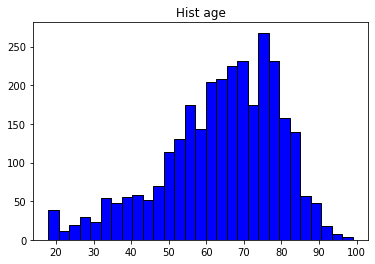

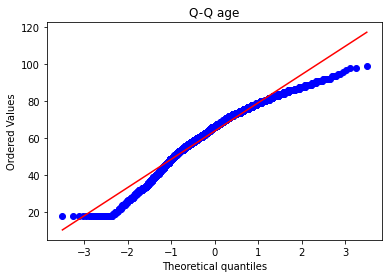

7.3566373496562255e-28


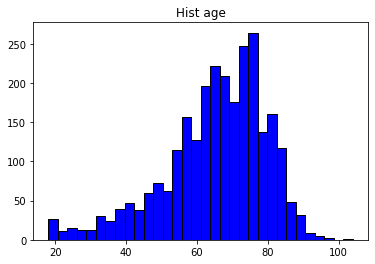

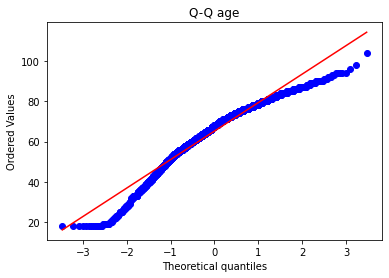

1.6397354305744558e-28


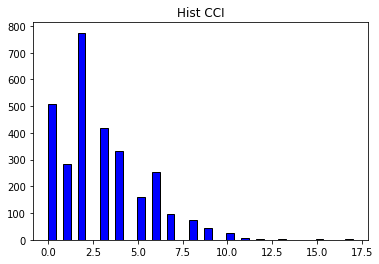

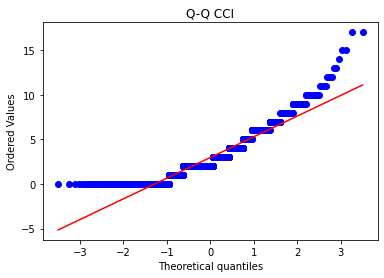

1.3774259436865795e-39


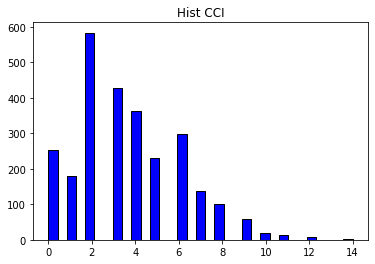

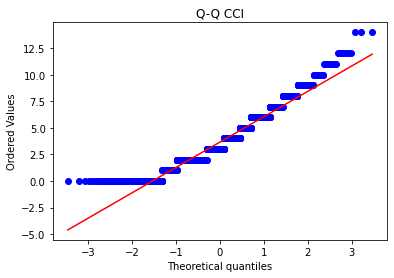

3.4483914832784595e-30


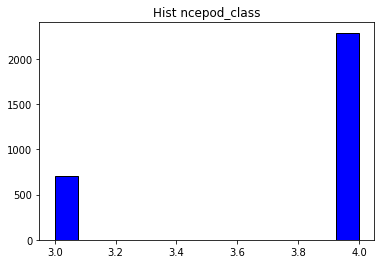

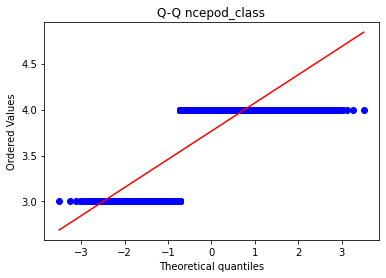

0.0


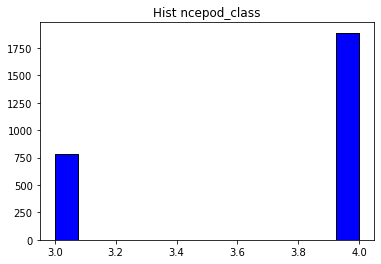

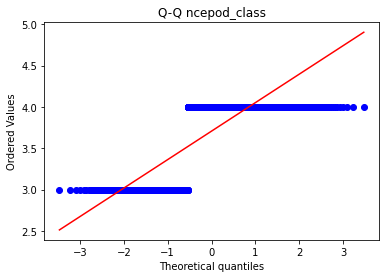

0.0


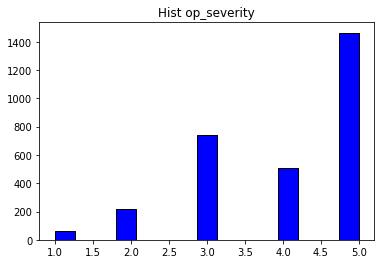

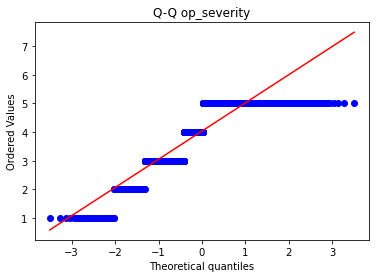

0.0


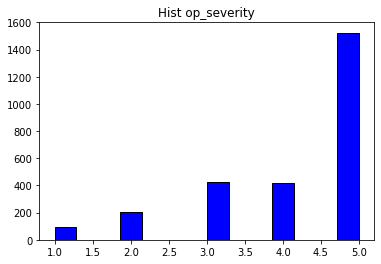

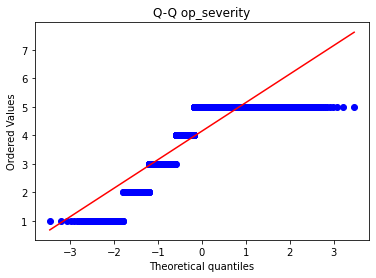

0.0


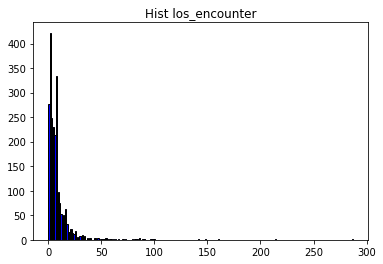

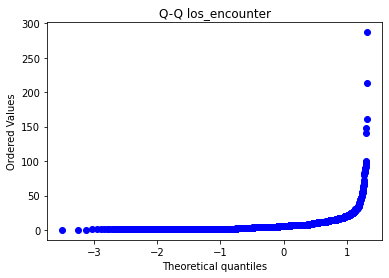

1.0


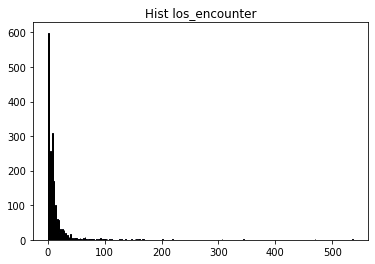

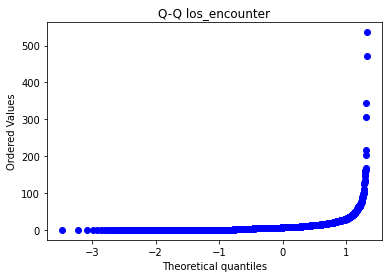

1.0


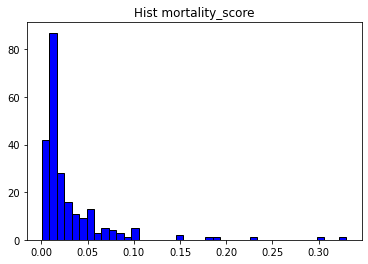

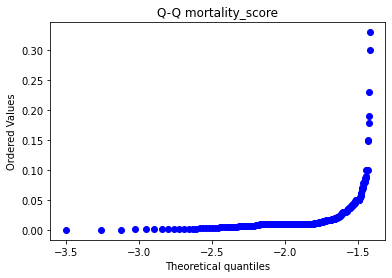

1.0


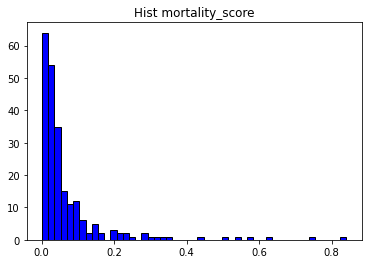

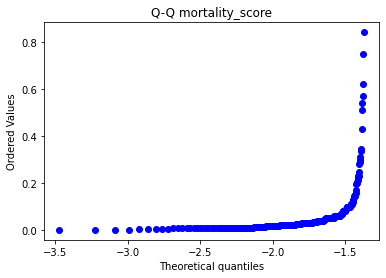

1.0


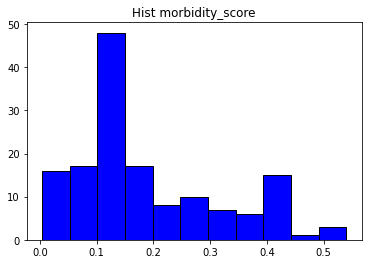

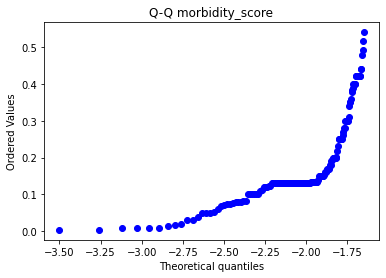

1.0


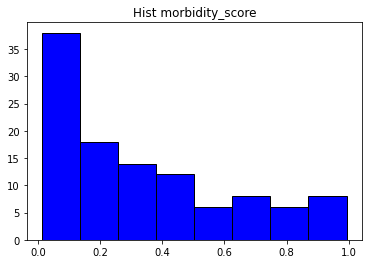

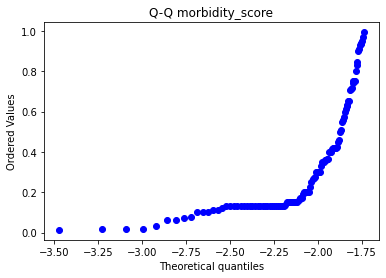

1.0


,n_whole,mean_whole,stdev_whole,median_whole,iqr_whole_low,iqr_whole_hi,count_ref_lvl1,mean_ref_lvl1,stdev_1,median_ref_lvl1,iqr_1_low,iqr_1_hi,count_ref_lvl23,mean_ref_lvl23,stdev_23,median_ref_lvl23,iqr_23_low,iqr_23_hi,p-value,test
age,0,64.5776535502021,15.051147083241231,67.0,56.0,76.0,0,63.996800293214825,15.558516333534484,66.0,55.50342465753425,76.0,0,65.2222633500123,14.438031654511084,68.0,57.0,76.0,0.008926232601223605,Wilcoxon Rank Sum
gender_female,2498,0.4411089528518453,0.49656357704035275,0.0,0.0,1.0,1368,0.45752508361204014,0.4982759455414528,0.0,0.0,1.0,1130,0.42290419161676646,0.49411295159899543,0.0,0.0,1.0,0.00953211768124388,Chi-Squared
white,4323,0.7633763023132615,0.42504685159500344,1.0,1.0,1.0,2228,0.7451505016722408,0.4358494750438902,1.0,0.0,1.0,2094,0.7836826347305389,0.41181018828725136,1.0,1.0,1.0,0.0007406429238618474,Chi-Squared
BAME,1339,0.23644711283771852,0.4249373623320725,0.0,0.0,0.0,762,0.2548494983277592,0.4358494750438902,0.0,0.0,1.0,577,0.2159431137724551,0.41155203105052174,0.0,0.0,0.0,0.000654341845388992,Chi-Squared
asian,303,0.05350520925304609,0.2250585392650918,0.0,0.0,0.0,146,0.04882943143812709,0.21554734223539357,0.0,0.0,0.0,157,0.05875748502994012,0.23521426131759232,0.0,0.0,0.0,0.11006036200181,Chi-Squared
black,169,0.02984283948437224,0.17016861592710208,0.0,0.0,0.0,98,0.03277591973244147,0.17807937816267552,0.0,0.0,0.0,71,0.02657185628742515,0.16085856109249388,0.0,0.0,0.0,0.19660167455421662,Chi-Squared
cardiac,1709,0.30178350697510153,0.4590723654253226,0.0,0.0,1.0,825,0.27591973244147155,0.44705131113345875,0.0,0.0,1.0,884,0.33083832335329344,0.47060302972840096,0.0,0.0,1.0,8.010347414451473e-06,Chi-Squared
kidney,765,0.13508740950026488,0.3418470957910778,0.0,0.0,0.0,382,0.1277591973244147,0.33387732345897897,0.0,0.0,0.0,383,0.1433383233532934,0.35048312494963607,0.0,0.0,0.0,0.09432884280165861,Chi-Squared
liver,354,0.06251103655306375,0.24210278223016046,0.0,0.0,0.0,163,0.05451505016722408,0.22706916073012057,0.0,0.0,0.0,191,0.07148203592814371,0.25767654864306283,0.0,0.0,0.0,0.009949816302690507,Chi-Squared
neuro,632,0.11160162458061099,0.3149034977086425,0.0,0.0,0.0,306,0.10234113712374582,0.3031470995207663,0.0,0.0,0.0,326,0.1220059880239521,0.32735398567479507,0.0,0.0,0.0,0.021250265618187894,Chi-Squared


In [26]:
comparisons = ['age', 'gender_female', 'white', 'BAME', 'asian', 'black', 'cardiac', 'kidney', 'liver', 'neuro', 'pulm', 'dementia', 'diabetes', 'comp_diabetes', 'htn', 'malignancy', 'metastasis', 'pvd', 'rheum', 'CCI', 'cancer_surgery', 'ncepod_class', 'op_severity', 'cancelled', 'cancel_nobed', 'los_encounter', 'died', 'died_6m', 'sop', 'cpet', 'clin_j', 'risk_score_patient', 'mortality_score', 'morbidity_score', 'over_8', '1-7_days', 'otd', 'ward_stepdowns', 'ward_stepdowns_nobed']

comparisons_data = []
for column in comparisons:
    data = comparison_analysis(title = column, data = [ref_lvl1[column], ref_lvl23[column], patient_dataset[column]])
    comparisons_data.append(data)
comparison_refs = pd.DataFrame(np.array(comparisons_data), columns = ['parameter', 'n_whole', 'mean_whole', 'stdev_whole', 'median_whole', 'iqr_whole_low', 'iqr_whole_hi', 'count_ref_lvl1', 'mean_ref_lvl1', 'stdev_1', 'median_ref_lvl1', 'iqr_1_low', 'iqr_1_hi', 'count_ref_lvl23', 'mean_ref_lvl23', 'stdev_23', 'median_ref_lvl23', 'iqr_23_low', 'iqr_23_hi', 'p-value', 'test']).set_index('parameter')
comparison_refs.index.name = None
comparison_refs.to_csv('comparison_refs.csv')
comparison_refs

## Multivariate models

### LOS Multivariate Linear Model

In [27]:
covars_los = ['age',
#            'gender_male',
            'gender_female',
#            'gender_non_binary',
#            'asian',
#            'black',
#            'mixed',
#            'white',
#            'other',
            'cardiac',
#            'kidney',
#            'liver',
            'neuro',
            'pulm',
#            'dementia',
            'diabetes',
#            'comp_diabetes',
#            'htn',
            'malignancy',
#            'metastasis',
#            'pvd',
#            'rheum',
#            'surgical_speciality',
#            'proposed_procedure',
            'cancer_surgery',
            'ncepod_class',
            'op_severity',
#            'scheduled_start',
#            'previous_cancellation',
#            'kts',
#            'cancelled',
#            'critical_care_7_days',
#            'encounter_start',
#            'encounter_end',
#            'los_encounter',
#            'los_0',
#            'los_1',
#            'los_2',
#            'los_3',
#            'died',
#            'died_date',
#            'cancel_nobed',
#            'cancel_other',
#            'cancel_other_text',
#            'sop',
#            'cpet',
#            'clin_j',
#            'risk_score_patient',
#            'score_text',
#            'mortality_score',
#            'morbidity_score',
#            'other_reason',
#            'refer_other_text',
#            'over_8',
#            '1-7_days',
#            'otd',
#            'proposed_lvl',
#            'actual_lvl',
#            'difference_nobed',
#            'difference_other',
#            'difference_other_text',
#            'difference_unknown',
            'BAME',
#            'CCI',
#            'los_23',
#            'los_recount',
#            '1stepdowns',
#            '1stepdowns_nobed',
#            '23to0stepdowns',
#            '23to0stepdowns_nobed',
#            '23to1stepdowns',
#            '23to1stepdowns_nobed',
#            'ward_stepdowns',
#            'ward_stepdowns_nobed',
#            'died_6m',
#            'level0-1_crit_care',
#            'level0-1_crit_care_7d',
#            'hospital_name',
            'type',
#            'icb',
#            'level_1',
#            'num_level_1',
#            'level_2',
#            'level_3',
#            'em_dept',
#            'services',
            'n_services',
#            'lvl_1_emer_adm',
#            'mdt',
#            'risk_score',
#            'procedure_based',
#            'clinical_judgement',
#            'ref_anaes',
#            'ref_surg',
#            'ref_nurse',
#            'ref_spr',
#            'no_vetting',
#            'vet_anaes',
#            'vet_icu',
#            'vet_surg',
#            'vet_nurse',
#            'alo_anaes',
#            'alo_icu',
#            'alo_surg',
#            'alo_nurse',
#            'bed_nurse',
#            'nurse_bed_esc',
#            'cover_cons',
#            'cover_spr',
#            'cover_sho',
#            'clin_anaes',
#            'clin_icu',
#            'clin_surg',
#            'discharge_anaes',
#            'discharge_icu',
#            'discharge_surg',
#            'periph_vaso',
#            'central_vaso',
#            'cpap',
#            'bipap',
#            'stay_limit',
#            'all_spec',
#            'single_spec',
#            'level_1_ring',
#            'level_1_cap',
#            'level_1_esc',
#            'level_2_ring',
#            'level_2_cap',
#            'level_2_esc',
#            'level_3_ring',
#            'level_3_cap',
#            'level_3_esc',
#            'level_23_ring',
#            'level_23_cap',
#            'level_23_esc',
#            'totalringcap',
            'total_op',
#            '%day',
#            'surg_adm',
#            '%emerg',
#            'cancel_per_1000_total',
#            'cancel_nobed_per_1000',
#            'c_ref_lvl1',
#            'c_plan_adm_lvl1',
#            'c_adm_lvl1',
#            'ref_lvl1_per_1000',
#            'plan_adm_lvl1_per_1000',
#            'adm_lvl1_per_1000',
#            '%emerg_lvl1',
#            'c_ref_lvl23',
#            'c_plan_adm_lvl23',
#            'c_adm_lvl23',
#            'ref_lvl23_per_1000',
#            'plan_adm_lvl23_per_1000',
#            'adm_lvl23_per_1000',
#            '%emerg_lvl23',
#            'EhC_refs',
#            'avg_age',
#            '%female',
#            '%white',
#            '%BAME',
#            '%asian',
#            '%black',
#            '%cardiac',
#            '%kidney',
#            '%liver',
#            '%neuro',
#            '%pulm',
#            '%dementia',
#            '%diabetes',
#            '%comp_diabetes',
#            '%htn',
#            '%malignancy',
#            '%metastasis',
#            '%pvd',
#            '%rheum',
#            'avg_CCI',
#            '%cancer_surgery',
#            'avg_ncepod',
#            'avg_severity',
#            '%cancelled',
#            '%cancelled_nobed',
#            '%level0-1_crit_care',
#            '%level0-1_crit_care_7d',
#            'LOS_mean',
#            'LOS_median',
#            'LOS1_mean',
#            'LOS1_median',
#            'LOS23_mean',
#            'LOS23_median',
#            '%died',
#            '%died_6m',
#            '%clin_j',
#            '%cpet',
#            '%sop',
#            '%risk_score',
#            'pred_mortality',
#            'pred_morbidity',
#            '%ref_over8',
#            '%ref_1_7',
#            '%ref_otd',
#            '%_1_ref_over8',
#            '%_1_ref_1_7',
#            '%_1_ref_otd',
#            '%_23_ref_over8',
#            '%_23_ref_1_7',
#            '%_23_ref_otd',
#            '%1stepdowns',
#            '%1stepdowns_nobed',
#            '%23to0stepdowns',
#            '%23to0stepdowns_nobed',
#            '%23to1stepdowns',
#            '%23to1stepdowns_nobed',
#            '%ward_stepdowns',
#            '%ward_stepdowns_nobed',
#            'ref_to_cap_1',
#            'ref_to_cap_23',
            'enhanced_care_ref',
#            'enhanced_care_adm'
                               ]


 GRAPHS OF UNIVARIATE ASSOCIATIONS ----



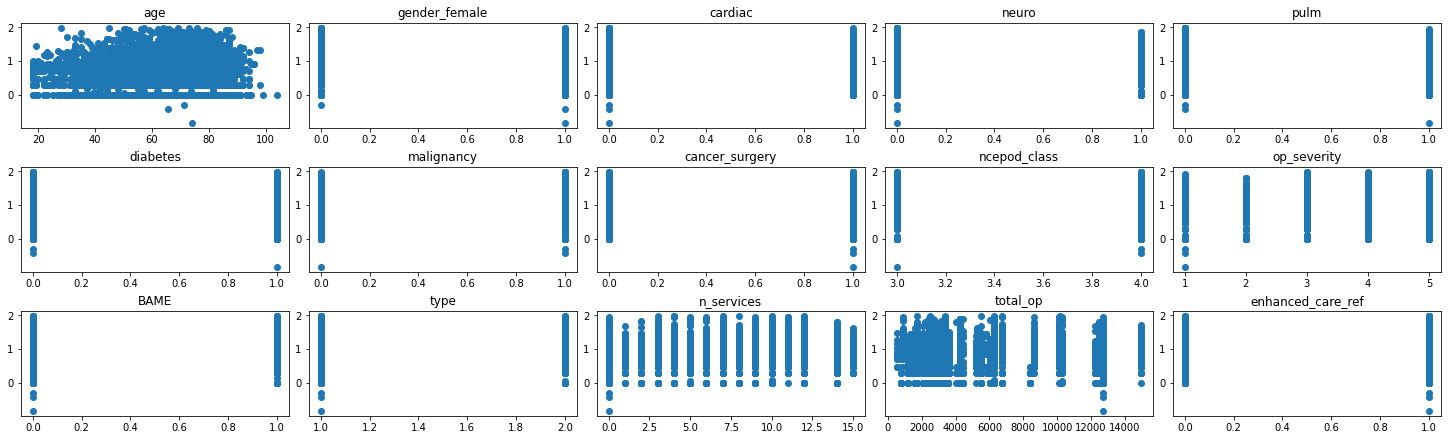


 ASSESSMENT OF UNIVARIATE ASSOCIATIONS ----

                            OLS Regression Results                            
Dep. Variable:          los_encounter   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     39.31
Date:                Mon, 24 Feb 2025   Prob (F-statistic):           3.91e-10
Time:                        18:05:56   Log-Likelihood:                -3067.5
No. Observations:                5033   AIC:                             6139.
Df Residuals:                    5031   BIC:                             6152.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

C:\Users\chris\AppData\Local\Temp\ipykernel_18792\3526545750.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(resids, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)
C:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


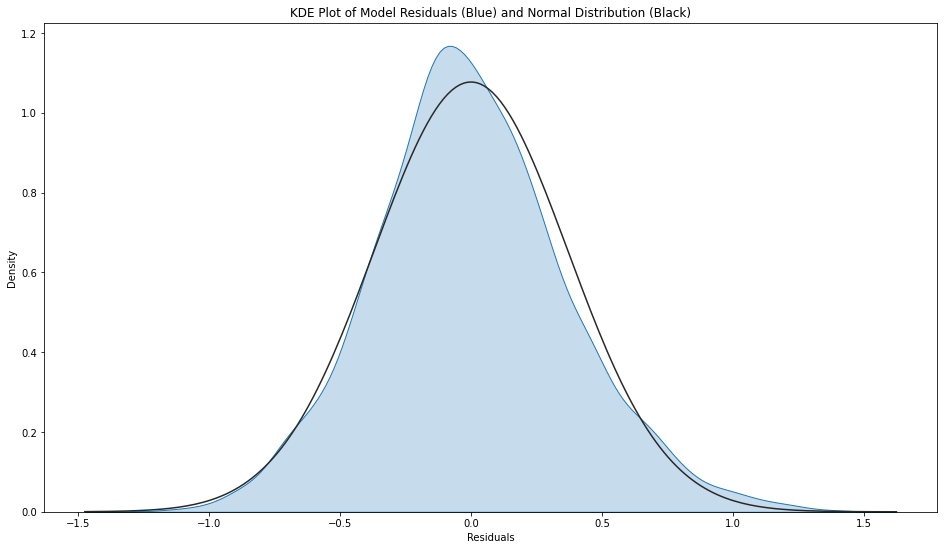

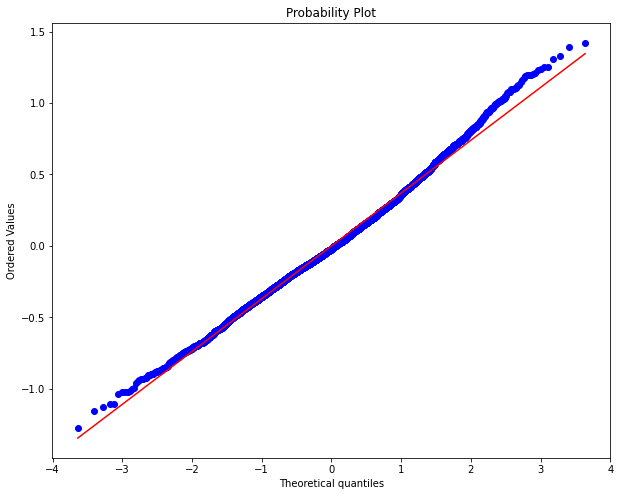

C:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\chris\AppData\Local\Temp\ipykernel_18792\3079330447.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[[item for item in indep_var.columns[1:]]].corr(),vmin=-1,annot= True)


ShapiroResult(statistic=0.9950584769248962, pvalue=4.419226703328283e-12)

 ASSESSMENT OF MULTICOLLINEARITY ----


 Variance Inflation Factor ----
age: 1.1408942062440446
gender_female: 1.0334395109355767
cardiac: 1.1495339577562533
neuro: 1.0341131220037687
pulm: 1.037433890337622
diabetes: 1.0316235957472897
malignancy: 2.055835556786392
cancer_surgery: 2.0746474347371984
ncepod_class: 1.040957017601648
op_severity: 1.1280840630288598
BAME: 1.0548786560063261
type: 1.463210862981783
n_services: 1.3515772451147923
total_op: 1.2710344594527787
enhanced_care_ref: 1.054855547322722


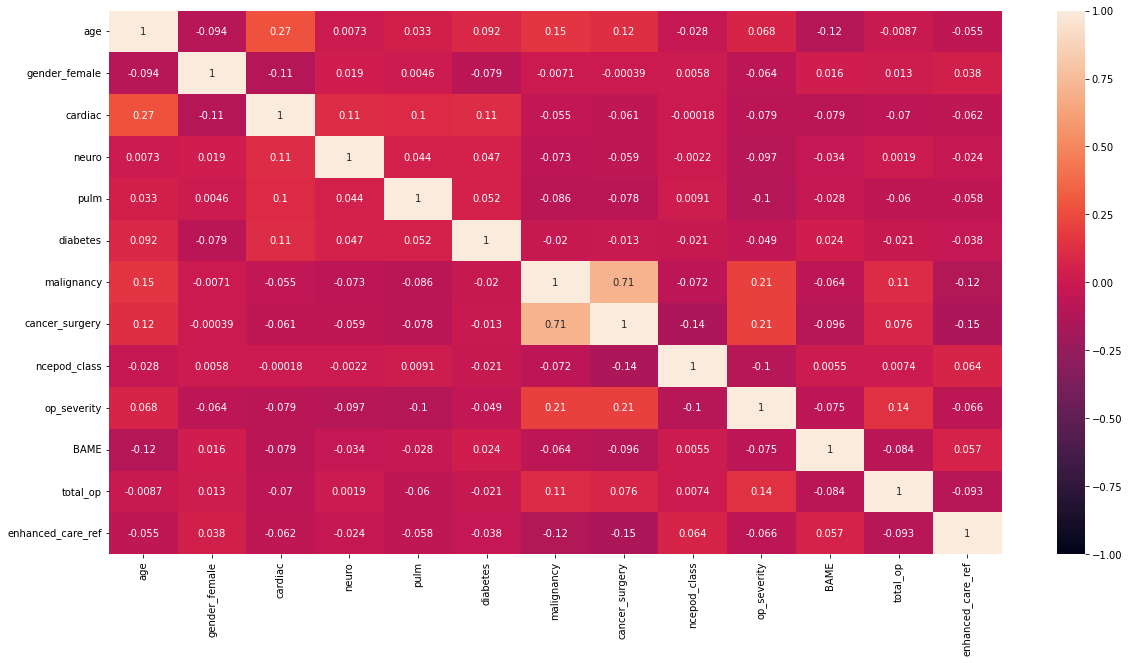


 ASSESSMENT OF HOMOSCEDASICITY ----


 White test ----
                                      value
Lagrange multiplier statistic  4.228206e+02
p-value                        2.881113e-34
f-value                        3.630122e+00
f p-value                      2.566322e-36

 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  1.568246e+02
p-value                        1.057775e-25
f-value                        1.075691e+01
f p-value                      3.860847e-26

 Goldfeld-Quandt test ----
                value
F statistic  0.968538
p-value      0.787904

 Residuals plots ----


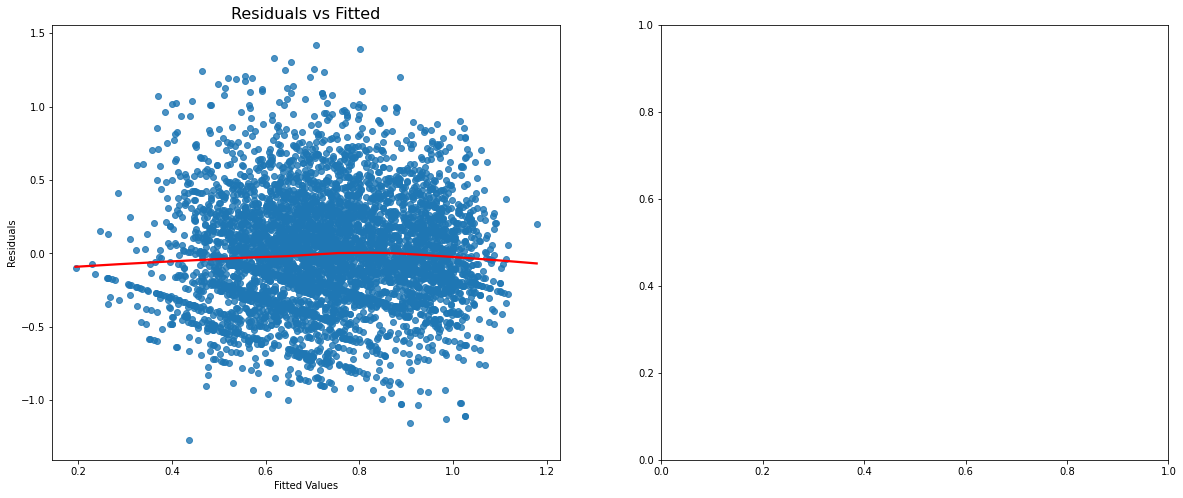


 ASSESSMENT OF INDEPENDENCE OF VARIABLES FROM THE ERROR TERM ----



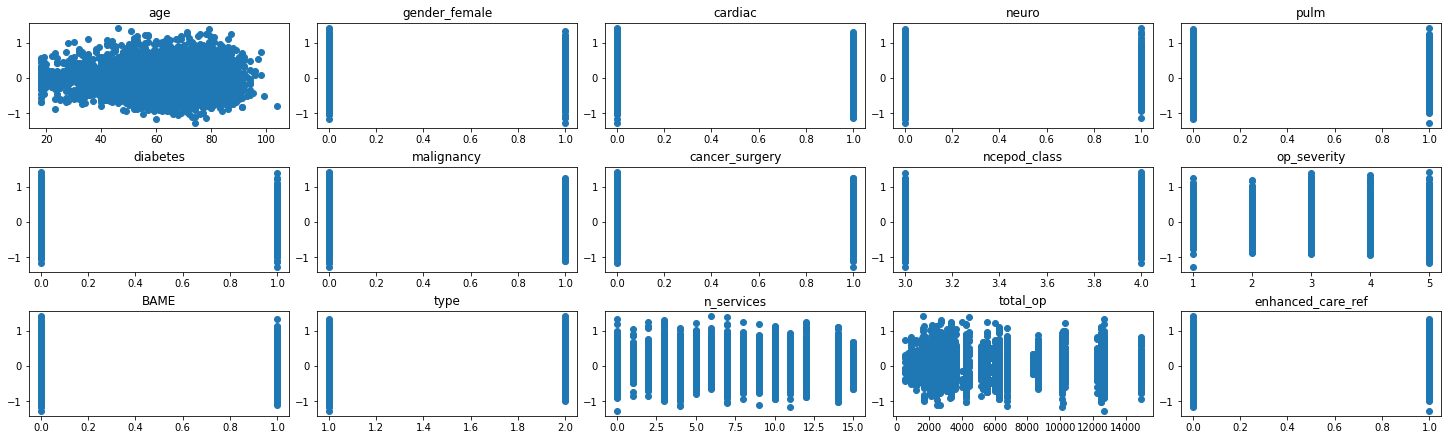


 ASSESSMENT OF INDEPENDENCE OF ERROR TERM VALUES ----



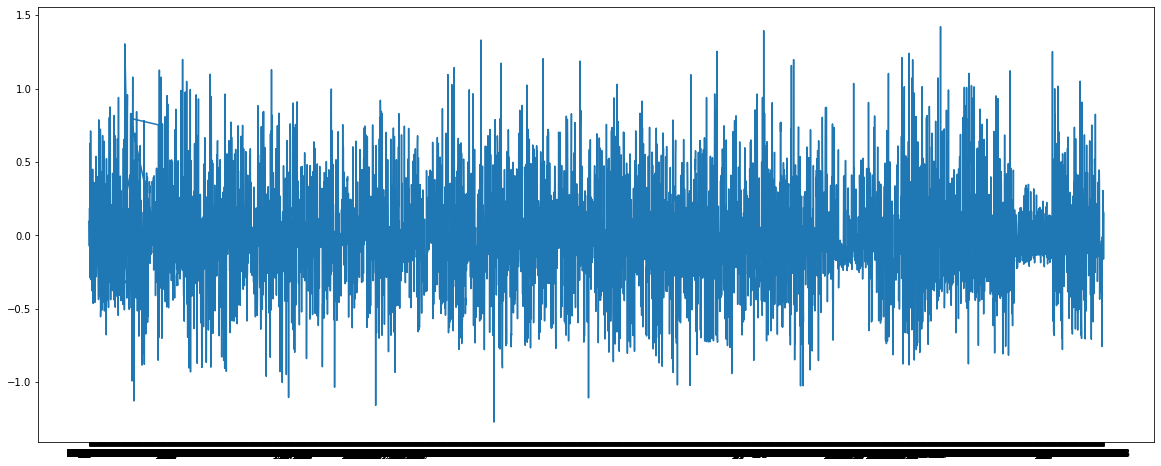


 REGRESSION RESULTS ----
            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: los_encounter
No. Observations:   5033    Method:             REML         
No. Groups:         59      Scale:              0.1389       
Min. group size:    1       Log-Likelihood:     -2309.6869   
Max. group size:    507     Converged:          Yes          
Mean group size:    85.3                                     
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
const              0.620    0.168   3.692 0.000  0.291  0.950
age                0.002    0.000   4.946 0.000  0.001  0.003
gender_female      0.005    0.011   0.500 0.617 -0.016  0.027
cardiac           -0.006    0.013  -0.439 0.660 -0.030  0.019
neuro             -0.009    0.018  -0.492 0.623 -0.045  0.027
pulm              -0.050    0.013  -3.898 0.000 -0.074 -

In [28]:
regress_assess(patient_nocancellations, 
               'los_encounter', 
               covars_los, 
               outlier_title='los_encounter', 
               outlier_low=0, 
               outlier_high=100, 
               group='hospital_name', 
               multi=True, log=True, 
               wls=False)

### Multivariate Logistic Models

#### Cancellation due to a lack of bed

In [29]:
covars_cancel_nobed = ['age',
#            'gender_male',
#            'gender_female',
#            'gender_non_binary',
#            'asian',
#            'black',
#            'mixed',
#            'white',
#            'other',
            'cardiac',
#            'kidney',
#            'liver',
            'neuro',
            'pulm',
#            'dementia',
#            'diabetes',
#            'comp_diabetes',
#            'htn',
#            'malignancy',
#            'metastasis',
#            'pvd',
#            'rheum',
#            'surgical_speciality',
#            'proposed_procedure',
            'cancer_surgery',
#            'ncepod_class',
            'op_severity',
#            'scheduled_start',
#            'previous_cancellation',
#            'kts',
#            'cancelled',
#            'critical_care_7_days',
#            'encounter_start',
#            'encounter_end',
#            'los_encounter',
#            'los_0',
#            'los_1',
#            'los_2',
#            'los_3',
#            'died',
#            'died_date',
#            'cancel_nobed',
#            'cancel_other',
#            'cancel_other_text',
            'sop',
#            'cpet',
            'clin_j',
#            'risk_score_patient',
#            'score_text',
#            'mortality_score',
#            'morbidity_score',
#            'other_reason',
#            'refer_other_text',
#            'over_8',
#            '1-7_days',
#            'otd',
#            'proposed_lvl',
#            'actual_lvl',
#            'difference_nobed',
#            'difference_other',
#            'difference_other_text',
#            'difference_unknown',
#            'BAME',
#            'CCI',
#            'los_23',
#            'los_recount',
#            '1stepdowns',
#            '1stepdowns_nobed',
#            '23to0stepdowns',
#            '23to0stepdowns_nobed',
#            '23to1stepdowns',
#            '23to1stepdowns_nobed',
#            'ward_stepdowns',
#            'ward_stepdowns_nobed',
#            'died_6m',
#            'level0-1_crit_care',
#            'level0-1_crit_care_7d',
#            'hospital_name',
#            'type',
#            'icb',
#            'level_1',
#            'num_level_1',
#            'level_2',
#            'level_3',
#            'em_dept',
#            'services',
#            'n_services',
#            'lvl_1_emer_adm',
#            'mdt',
#            'risk_score',
#            'procedure_based',
#            'clinical_judgement',
#            'ref_anaes',
#            'ref_surg',
#            'ref_nurse',
#            'ref_spr',
#            'no_vetting',
#            'vet_anaes',
#            'vet_icu',
#            'vet_surg',
#            'vet_nurse',
#            'alo_anaes',
#            'alo_icu',
#            'alo_surg',
#            'alo_nurse',
#            'bed_nurse',
#            'nurse_bed_esc',
#            'cover_cons',
#            'cover_spr',
#            'cover_sho',
#            'clin_anaes',
#            'clin_icu',
#            'clin_surg',
#            'discharge_anaes',
#            'discharge_icu',
#            'discharge_surg',
#            'periph_vaso',
#            'central_vaso',
#            'cpap',
#            'bipap',
#            'stay_limit',
#            'all_spec',
#            'single_spec',
#            'level_1_ring',
            'level_1_cap',
#            'level_1_esc',
#            'level_2_ring',
#            'level_2_cap',
#            'level_2_esc',
#            'level_3_ring',
#            'level_3_cap',
#            'level_3_esc',
#            'level_23_ring',
            'level_23_cap',
#            'level_23_esc',
#            'totalringcap',
#            'total_op',
#            '%day',
#            'surg_adm',
#            '%emerg',
#            'cancel_per_1000_total',
#            'cancel_nobed_per_1000',
#            'c_ref_lvl1',
#            'c_plan_adm_lvl1',
#            'c_adm_lvl1',
#            'ref_lvl1_per_1000',
#            'plan_adm_lvl1_per_1000',
#            'adm_lvl1_per_1000',
#            '%emerg_lvl1',
#            'c_ref_lvl23',
#            'c_plan_adm_lvl23',
#            'c_adm_lvl23',
#            'ref_lvl23_per_1000',
#            'plan_adm_lvl23_per_1000',
            'adm_lvl23_per_1000',
#            '%emerg_lvl23',
#            'EhC_refs',
#            'avg_age',
#            '%female',
#            '%white',
#            '%BAME',
#            '%asian',
#            '%black',
#            '%cardiac',
#            '%kidney',
#            '%liver',
#            '%neuro',
#            '%pulm',
#            '%dementia',
#            '%diabetes',
#            '%comp_diabetes',
#            '%htn',
#            '%malignancy',
#            '%metastasis',
#            '%pvd',
#            '%rheum',
#            'avg_CCI',
#            '%cancer_surgery',
#            'avg_ncepod',
#            'avg_severity',
#            '%cancelled',
#            '%cancelled_nobed',
#            '%level0-1_crit_care',
#            '%level0-1_crit_care_7d',
#            'LOS_mean',
#            'LOS_median',
#            'LOS1_mean',
#            'LOS1_median',
#            'LOS23_mean',
#            'LOS23_median',
#            '%died',
#            '%died_6m',
#            '%clin_j',
#            '%cpet',
#            '%sop',
#            '%risk_score',
#            'pred_mortality',
#            'pred_morbidity',
#            '%ref_over8',
#            '%ref_1_7',
            '%ref_otd',
#            '%_1_ref_over8',
#            '%_1_ref_1_7',
#            '%_1_ref_otd',
#            '%_23_ref_over8',
#            '%_23_ref_1_7',
#            '%_23_ref_otd',
#            '%1stepdowns',
#            '%1stepdowns_nobed',
#            '%23to0stepdowns',
#            '%23to0stepdowns_nobed',
#            '%23to1stepdowns',
#            '%23to1stepdowns_nobed',
            '%ward_stepdowns',
#            '%ward_stepdowns_nobed',
#            'ref_to_cap_1',
#            'ref_to_cap_23',
            'enhanced_care_ref',
#            'enhanced_care_adm'
                               ]

Optimization terminated successfully.
         Current function value: 0.142044
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           cancel_nobed   No. Observations:                 5663
Model:                          Logit   Df Residuals:                     5661
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:               0.0003838
Time:                        18:06:31   Log-Likelihood:                -804.40
converged:                       True   LL-Null:                       -804.71
Covariance Type:            nonrobust   LLR p-value:                    0.4319
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1562      0.321     -9.823      0.000      -3.786      -2.526
age           -0.0039      0.

C:\Users\chris\AppData\Local\Temp\ipykernel_18792\3079330447.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[[item for item in indep_var.columns[1:]]].corr(),vmin=-1,annot= True)


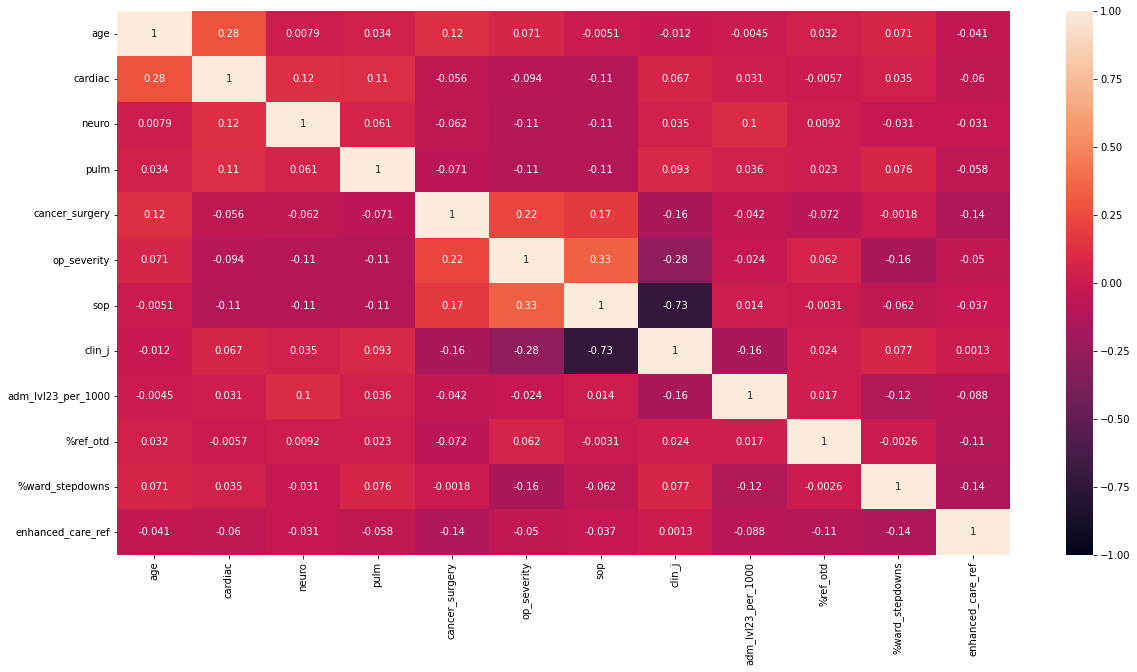

                           Logit Regression Results                           
Dep. Variable:           cancel_nobed   No. Observations:                 5663
Model:                          Logit   Df Residuals:                     5648
Method:                           MLE   Df Model:                           14
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.08224
Time:                        18:06:32   Log-Likelihood:                -738.53
converged:                       True   LL-Null:                       -804.71
Covariance Type:            nonrobust   LLR p-value:                 2.331e-21
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -2.1555      0.520     -4.146      0.000      -3.175      -1.136
age                   -0.0056      0.005     -1.040      0.298      -0.016       0.005
cardiac             

In [30]:
dep_var = patient_dataset['cancel_nobed']
dep_var = dep_var.fillna(0)
indep_var = patient_dataset[covars_cancel_nobed].fillna(0)

for variable in covars_cancel_nobed:
    temp_indep = sm.tools.tools.add_constant(patient_dataset[variable])
    temp_indep = temp_indep.fillna(0)
    temp_model = sm.discrete.discrete_model.Logit(dep_var, temp_indep).fit()
    print(temp_model.summary())

indep_var = sm.tools.tools.add_constant(indep_var)
model = sm.discrete.discrete_model.Logit(dep_var, indep_var).fit()
multicol(patient_dataset, indep_var)
print(model.summary())

#### Cancellation

In [31]:
covars_cancelled = ['age',
#            'gender_male',
#            'gender_female',
#            'gender_non_binary',
#            'asian',
#            'black',
#            'mixed',
#            'white',
#            'other',
            'cardiac',
#            'kidney',
#            'liver',
            'neuro',
            'pulm',
#            'dementia',
#            'diabetes',
#            'comp_diabetes',
#            'htn',
#            'malignancy',
#            'metastasis',
#            'pvd',
#            'rheum',
#            'surgical_speciality',
#            'proposed_procedure',
            'cancer_surgery',
#            'ncepod_class',
            'op_severity',
#            'scheduled_start',
#            'previous_cancellation',
#            'kts',
#            'cancelled',
#            'critical_care_7_days',
#            'encounter_start',
#            'encounter_end',
#            'los_encounter',
#            'los_0',
#            'los_1',
#            'los_2',
#            'los_3',
#            'died',
#            'died_date',
#            'cancel_nobed',
#            'cancel_other',
#            'cancel_other_text',
            'sop',
#            'cpet',
            'clin_j',
#            'risk_score_patient',
#            'score_text',
#            'mortality_score',
#            'morbidity_score',
#            'other_reason',
#            'refer_other_text',
#            'over_8',
#            '1-7_days',
            'otd',
#            'proposed_lvl',
#            'actual_lvl',
#            'difference_nobed',
#            'difference_other',
#            'difference_other_text',
#            'difference_unknown',
#            'BAME',
#            'CCI',
#            'los_23',
#            'los_recount',
#            '1stepdowns',
#            '1stepdowns_nobed',
#            '23to0stepdowns',
#            '23to0stepdowns_nobed',
#            '23to1stepdowns',
#            '23to1stepdowns_nobed',
#            'ward_stepdowns',
#            'ward_stepdowns_nobed',
#            'died_6m',
#            'level0-1_crit_care',
#            'level0-1_crit_care_7d',
#            'hospital_name',
#            'type',
#            'icb',
#            'level_1',
#            'num_level_1',
#            'level_2',
#            'level_3',
            'em_dept',
#            'services',
            'n_services',
#            'lvl_1_emer_adm',
#            'mdt',
#            'risk_score',
#            'procedure_based',
#            'clinical_judgement',
#            'ref_anaes',
#            'ref_surg',
#            'ref_nurse',
#            'ref_spr',
#            'no_vetting',
#            'vet_anaes',
#            'vet_icu',
#            'vet_surg',
#            'vet_nurse',
#            'alo_anaes',
#            'alo_icu',
#            'alo_surg',
#            'alo_nurse',
#            'bed_nurse',
#            'nurse_bed_esc',
#            'cover_cons',
#            'cover_spr',
#            'cover_sho',
#            'clin_anaes',
#            'clin_icu',
#            'clin_surg',
#            'discharge_anaes',
#            'discharge_icu',
#            'discharge_surg',
#            'periph_vaso',
#            'central_vaso',
#            'cpap',
#            'bipap',
#            'stay_limit',
#            'all_spec',
#            'single_spec',
#            'level_1_ring',
            'level_1_cap',
#            'level_1_esc',
#            'level_2_ring',
#            'level_2_cap',
#            'level_2_esc',
#            'level_3_ring',
#            'level_3_cap',
#            'level_3_esc',
#            'level_23_ring',
#            'level_23_cap',
#            'level_23_esc',
#            'totalringcap',
#            'total_op',
#            '%day',
#            'surg_adm',
#            '%emerg',
#            'cancel_per_1000_total',
#            'cancel_nobed_per_1000',
#            'c_ref_lvl1',
#            'c_plan_adm_lvl1',
#            'c_adm_lvl1',
#            'ref_lvl1_per_1000',
#            'plan_adm_lvl1_per_1000',
#            'adm_lvl1_per_1000',
#            '%emerg_lvl1',
#            'c_ref_lvl23',
#            'c_plan_adm_lvl23',
#            'c_adm_lvl23',
#            'ref_lvl23_per_1000',
#            'plan_adm_lvl23_per_1000',
            'adm_lvl23_per_1000',
#            '%emerg_lvl23',
            'EhC_refs',
#            'avg_age',
#            '%female',
#            '%white',
#            '%BAME',
#            '%asian',
#            '%black',
#            '%cardiac',
#            '%kidney',
#            '%liver',
#            '%neuro',
#            '%pulm',
#            '%dementia',
#            '%diabetes',
#            '%comp_diabetes',
#            '%htn',
#            '%malignancy',
#            '%metastasis',
#            '%pvd',
#            '%rheum',
#            'avg_CCI',
#            '%cancer_surgery',
#            'avg_ncepod',
#            'avg_severity',
#            '%cancelled',
#            '%cancelled_nobed',
#            '%level0-1_crit_care',
#            '%level0-1_crit_care_7d',
#            'LOS_mean',
#            'LOS_median',
#            'LOS1_mean',
#            'LOS1_median',
#            'LOS23_mean',
#            'LOS23_median',
#            '%died',
#            '%died_6m',
#            '%clin_j',
#            '%cpet',
#            '%sop',
#            '%risk_score',
#            'pred_mortality',
#            'pred_morbidity',
#            '%ref_over8',
#            '%ref_1_7',
#            '%ref_otd',
#            '%_1_ref_over8',
#            '%_1_ref_1_7',
#            '%_1_ref_otd',
#            '%_23_ref_over8',
#            '%_23_ref_1_7',
#            '%_23_ref_otd',
#            '%1stepdowns',
#            '%1stepdowns_nobed',
#            '%23to0stepdowns',
#            '%23to0stepdowns_nobed',
#            '%23to1stepdowns',
#            '%23to1stepdowns_nobed',
#            '%ward_stepdowns',
#            '%ward_stepdowns_nobed',
#            'ref_to_cap_1',
#            'ref_to_cap_23',
            'enhanced_care_ref',
#            'enhanced_care_adm'
                               ]

Optimization terminated successfully.
         Current function value: 0.296070
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              cancelled   No. Observations:                 5663
Model:                          Logit   Df Residuals:                     5661
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:               6.370e-05
Time:                        18:06:32   Log-Likelihood:                -1676.6
converged:                       True   LL-Null:                       -1676.7
Covariance Type:            nonrobust   LLR p-value:                    0.6440
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2551      0.205    -10.985      0.000      -2.658      -1.853
age           -0.0014      0.

C:\Users\chris\AppData\Local\Temp\ipykernel_18792\3079330447.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[[item for item in indep_var.columns[1:]]].corr(),vmin=-1,annot= True)


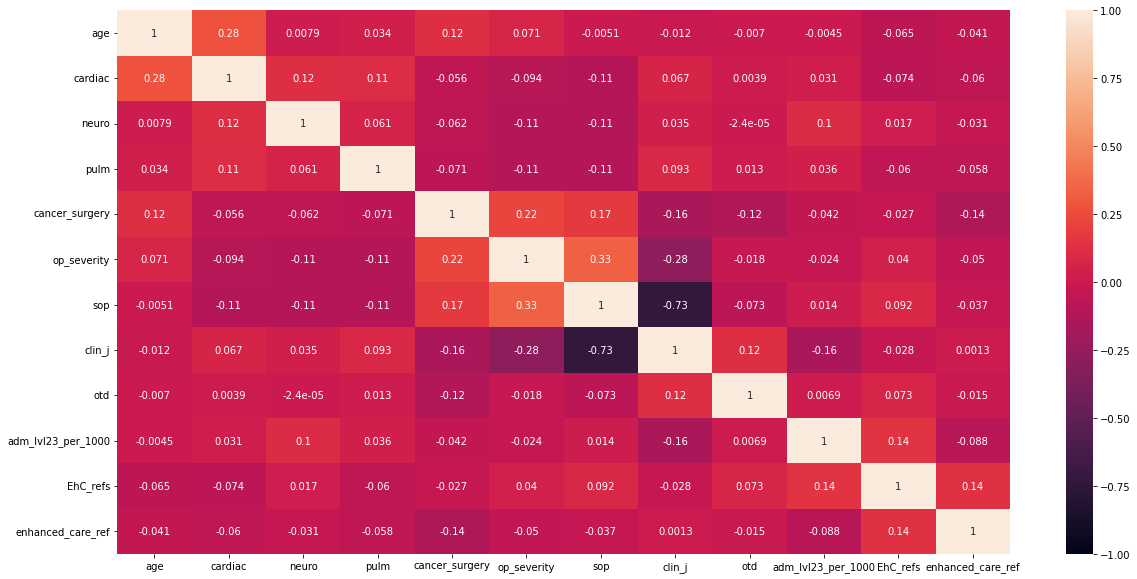

                           Logit Regression Results                           
Dep. Variable:              cancelled   No. Observations:                 5663
Model:                          Logit   Df Residuals:                     5647
Method:                           MLE   Df Model:                           15
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.05043
Time:                        18:06:33   Log-Likelihood:                -1592.2
converged:                       True   LL-Null:                       -1676.7
Covariance Type:            nonrobust   LLR p-value:                 3.661e-28
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.8246      0.326     -5.594      0.000      -2.464      -1.185
age                   -0.0032      0.003     -0.944      0.345      -0.010       0.003
cardiac             

In [32]:
dep_var = patient_dataset['cancelled']
dep_var = dep_var.fillna(0)
indep_var = patient_dataset[covars_cancelled].fillna(0)

for variable in covars_cancelled:
    temp_indep = sm.tools.tools.add_constant(patient_dataset[variable])
    temp_indep = temp_indep.fillna(0)
    temp_model = sm.discrete.discrete_model.Logit(dep_var, temp_indep).fit()
    print(temp_model.summary())

indep_var = sm.tools.tools.add_constant(indep_var)
model = sm.discrete.discrete_model.Logit(dep_var, indep_var).fit()
multicol(patient_dataset, indep_var)
print(model.summary())

#### Mortality within 6 months

In [33]:
covars_died_6m = ['age',
#            'gender_male',
#            'gender_female',
#            'gender_non_binary',
#            'asian',
#            'black',
#            'mixed',
#            'white',
#            'other',
            'cardiac',
            'kidney',
#            'liver',
            'neuro',
            'pulm',
            'dementia',
#            'diabetes',
#            'comp_diabetes',
#            'htn',
#            'malignancy',
#            'metastasis',
#            'pvd',
#            'rheum',
#            'surgical_speciality',
#            'proposed_procedure',
            'cancer_surgery',
            'ncepod_class',
            'op_severity',
#            'scheduled_start',
#            'previous_cancellation',
#            'kts',
#            'cancelled',
#            'critical_care_7_days',
#            'encounter_start',
#            'encounter_end',
#            'los_encounter',
#            'los_0',
#            'los_1',
#            'los_2',
#            'los_3',
#            'died',
#            'died_date',
#            'cancel_nobed',
#            'cancel_other',
#            'cancel_other_text',
#            'sop',
#            'cpet',
#            'clin_j',
#            'risk_score_patient',
#            'score_text',
#            'mortality_score',
#            'morbidity_score',
#            'other_reason',
#            'refer_other_text',
            'over_8',
#            '1-7_days',
            'otd',
#            'proposed_lvl',
            'actual_lvl',
#            'difference_nobed',
#            'difference_other',
#            'difference_other_text',
#            'difference_unknown',
#            'BAME',
            'CCI',
#            'los_23',
#            'los_recount',
#            '1stepdowns',
#            '1stepdowns_nobed',
#            '23to0stepdowns',
#            '23to0stepdowns_nobed',
#            '23to1stepdowns',
#            '23to1stepdowns_nobed',
#            'ward_stepdowns',
#            'ward_stepdowns_nobed',
#            'died_6m',
#            'level0-1_crit_care',
#            'level0-1_crit_care_7d',
#            'hospital_name',
            'type',
#            'icb',
#            'level_1',
#            'num_level_1',
#            'level_2',
#            'level_3',
#            'em_dept',
#            'services',
#            'n_services',
#            'lvl_1_emer_adm',
#            'mdt',
#            'risk_score',
#            'procedure_based',
#            'clinical_judgement',
#            'ref_anaes',
#            'ref_surg',
#            'ref_nurse',
#            'ref_spr',
#            'no_vetting',
#            'vet_anaes',
#            'vet_icu',
#            'vet_surg',
#            'vet_nurse',
#            'alo_anaes',
#            'alo_icu',
#            'alo_surg',
#            'alo_nurse',
#            'bed_nurse',
#            'nurse_bed_esc',
#            'cover_cons',
#            'cover_spr',
#            'cover_sho',
#            'clin_anaes',
#            'clin_icu',
#            'clin_surg',
#            'discharge_anaes',
#            'discharge_icu',
#            'discharge_surg',
#            'periph_vaso',
#            'central_vaso',
#            'cpap',
#            'bipap',
#            'stay_limit',
#            'all_spec',
#            'single_spec',
#            'level_1_ring',
#            'level_1_cap',
#            'level_1_esc',
#            'level_2_ring',
#            'level_2_cap',
#            'level_2_esc',
#            'level_3_ring',
#            'level_3_cap',
#            'level_3_esc',
#            'level_23_ring',
#            'level_23_cap',
#            'level_23_esc',
#            'totalringcap',
            'total_op',
#            '%day',
#            'surg_adm',
#            '%emerg',
#            'cancel_per_1000_total',
#            'cancel_nobed_per_1000',
#            'c_ref_lvl1',
#            'c_plan_adm_lvl1',
#            'c_adm_lvl1',
#            'ref_lvl1_per_1000',
#            'plan_adm_lvl1_per_1000',
#            'adm_lvl1_per_1000',
#            '%emerg_lvl1',
#            'c_ref_lvl23',
#            'c_plan_adm_lvl23',
#            'c_adm_lvl23',
#            'ref_lvl23_per_1000',
#            'plan_adm_lvl23_per_1000',
#            'adm_lvl23_per_1000',
#            '%emerg_lvl23',
#            'EhC_refs',
#            'avg_age',
#            '%female',
#            '%white',
#            '%BAME',
#            '%asian',
#            '%black',
#            '%cardiac',
#            '%kidney',
#            '%liver',
#            '%neuro',
#            '%pulm',
#            '%dementia',
#            '%diabetes',
#            '%comp_diabetes',
#            '%htn',
#            '%malignancy',
#            '%metastasis',
#            '%pvd',
#            '%rheum',
#            'avg_CCI',
#            '%cancer_surgery',
#            'avg_ncepod',
#            'avg_severity',
#            '%cancelled',
#            '%cancelled_nobed',
#            '%level0-1_crit_care',
#            '%level0-1_crit_care_7d',
#            'LOS_mean',
#            'LOS_median',
#            'LOS1_mean',
#            'LOS1_median',
#            'LOS23_mean',
#            'LOS23_median',
#            '%died',
#            '%died_6m',
#            '%clin_j',
#            '%cpet',
#            '%sop',
#            '%risk_score',
#            'pred_mortality',
#            'pred_morbidity',
#            '%ref_over8',
#            '%ref_1_7',
#            '%ref_otd',
#            '%_1_ref_over8',
#            '%_1_ref_1_7',
#            '%_1_ref_otd',
#            '%_23_ref_over8',
#            '%_23_ref_1_7',
#            '%_23_ref_otd',
#            '%1stepdowns',
#            '%1stepdowns_nobed',
#            '%23to0stepdowns',
#            '%23to0stepdowns_nobed',
#            '%23to1stepdowns',
#            '%23to1stepdowns_nobed',
            '%ward_stepdowns',
#            '%ward_stepdowns_nobed',
#            'ref_to_cap_1',
#            'ref_to_cap_23',
            'enhanced_care_ref',
#            'enhanced_care_adm'
                               ]

Optimization terminated successfully.
         Current function value: 0.126962
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                died_6m   No. Observations:                 5169
Model:                          Logit   Df Residuals:                     5167
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.01265
Time:                        18:06:33   Log-Likelihood:                -656.27
converged:                       True   LL-Null:                       -664.68
Covariance Type:            nonrobust   LLR p-value:                 4.111e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2385      0.458    -11.427      0.000      -6.137      -4.340
age            0.0254      0.

C:\Users\chris\AppData\Local\Temp\ipykernel_18792\3079330447.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[[item for item in indep_var.columns[1:]]].corr(),vmin=-1,annot= True)


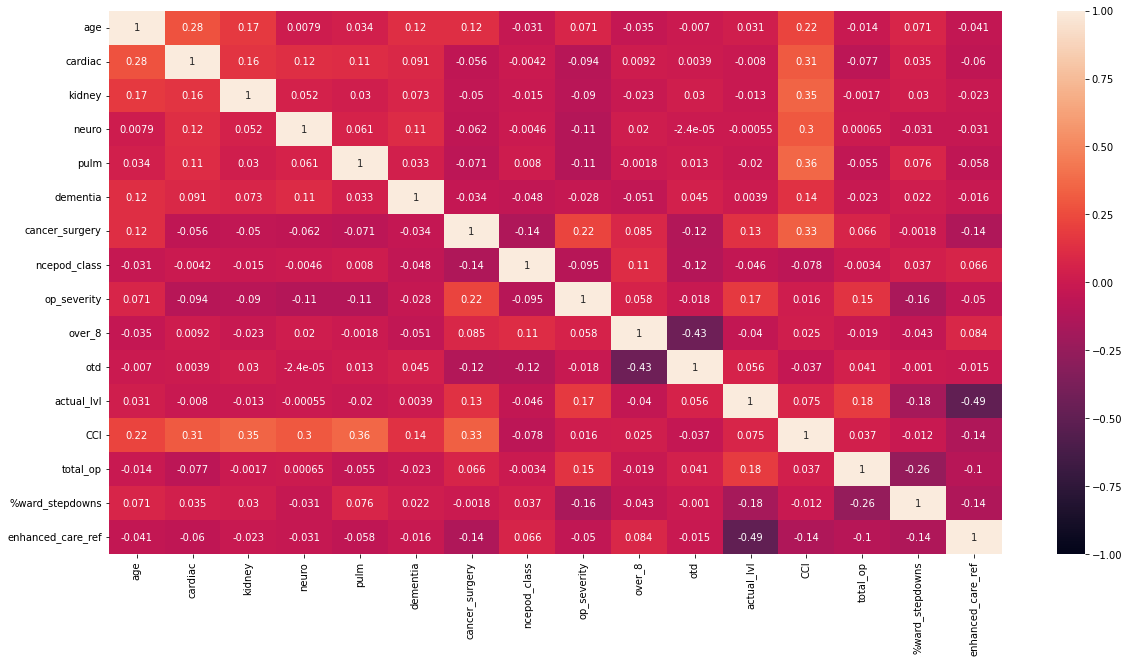

                           Logit Regression Results                           
Dep. Variable:                died_6m   No. Observations:                 5169
Model:                          Logit   Df Residuals:                     5151
Method:                           MLE   Df Model:                           17
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                 0.09575
Time:                        18:06:34   Log-Likelihood:                -601.03
converged:                       True   LL-Null:                       -664.68
Covariance Type:            nonrobust   LLR p-value:                 6.217e-19
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.5105      1.028     -5.362      0.000      -7.525      -3.496
age                   0.0202      0.007      2.820      0.005       0.006       0.034
cardiac               0.

In [34]:
dep_var = patient_nocancellations['died_6m']
dep_var = dep_var.fillna(0)
indep_var = patient_nocancellations[covars_died_6m].fillna(0)

for variable in covars_died_6m:
    temp_indep = sm.tools.tools.add_constant(patient_nocancellations[variable])
    temp_indep = temp_indep.fillna(0)
    temp_model = sm.discrete.discrete_model.Logit(dep_var, temp_indep).fit()
    print(temp_model.summary())

indep_var = sm.tools.tools.add_constant(indep_var)
model = sm.discrete.discrete_model.Logit(dep_var, indep_var).fit()
multicol(patient_dataset, indep_var)
print(model.summary())

## Things to add to anaylsis

In [35]:
#GLM websites
#https://sandipanpaul.medium.com/linear-regression-assumptions-in-python-in-short-16151b4ec717
#https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression

#Analysis
#Analyse the impact of particular structures of enhanced care (e.g. nurse referral) on what type of patients get admitted, referral to capacity ratio etc
#Penalisation via LASSO for analysis
#Look into fragility index for conclusions
#Something similar to this would be good for the level 1 units figure https://stackoverflow.com/questions/66279511/matplotlib-colorbar-some-ticks-appear-without-labels
#Assess if type of unit 1-4 has any bearing on outcome measures
#Create values for ITU capacity and total admissions from ICNARC data, attempt to get this from Wales

#The observation that being referred on the day predicts a lower risk of cancellation is very likely to reflect a bias in the dataset
#i.e. if you are referred on the day then cancelled for this reason it is unlikely this will be captured by our data collection method
#it may be fair to assume that if you are referred on the day then the liklihood of cancellation if a bed isn't avaialable is also low
#it is also unlikely that those referred on the day who go ahead but are admitted to the ward will have been captured

In [36]:
#Things to ask statistician

#Why are the shapiro results for the univaraiate comparisons the way they are?
#There are several non-normal distributions visually that have a shapiro value of 1, and there are some roughly normal relationships with very small shapiro values
#How do I approach the multivariate models with respect to homoscedasicity?
#How should I go about variable selection, I was planning to do this based on clinical plausibility but there are lots of variables that more or less describe the same thing
#What is the most valid way to adjust the main exploratory variable

In [37]:
patient_covars = ['age',
#            'gender_male',
            'gender_female',
#            'gender_non_binary',
#            'asian',
#            'black',
#            'mixed',
#            'white',
#            'other',
            'cardiac',
            'kidney',
            'liver',
            'neuro',
            'pulm',
#            'dementia',
            'diabetes',
#            'comp_diabetes',
#            'htn',
            'malignancy',
#            'metastasis',
#            'pvd',
#            'rheum',
#            'surgical_speciality',
#            'proposed_procedure',
            'cancer_surgery',
            'ncepod_class',
            'op_severity',
#            'scheduled_start',
#            'previous_cancellation',
#            'kts',
#            'cancelled',
#            'critical_care_7_days',
#            'encounter_start',
#            'encounter_end',
#            'los_encounter',
#            'los_0',
#            'los_1',
#            'los_2',
#            'los_3',
#            'died',
#            'died_date',
#            'cancel_nobed',
#            'cancel_other',
#            'cancel_other_text',
            'sop',
            'cpet',
            'clin_j',
            'risk_score_patient',
#            'score_text',
#            'mortality_score',
#            'morbidity_score',
#            'other_reason',
#            'refer_other_text',
            'over_8',
            '1-7_days',
            'otd',
#            'proposed_lvl',
#            'actual_lvl',
#            'difference_nobed',
#            'difference_other',
#            'difference_other_text',
#            'difference_unknown',
            'BAME',
            'CCI',
#            'los_23',
#            'los_recount',
#            '1stepdowns',
#            '1stepdowns_nobed',
#            '23to0stepdowns',
#            '23to0stepdowns_nobed',
#            '23to1stepdowns',
#            '23to1stepdowns_nobed',
#            'ward_stepdowns',
#            'ward_stepdowns_nobed',
#            'died_6m',
#            'level0-1_crit_care',
#            'level0-1_crit_care_7d',
#            'hospital_name',
            'type',
#            'icb',
#            'level_1',
#            'num_level_1',
#            'level_2',
#            'level_3',
            'em_dept',
#            'services',
#            'lvl_1_emer_adm',
#            'mdt',
#            'risk_score',
#            'procedure_based',
#            'clinical_judgement',
#            'ref_anaes',
#            'ref_surg',
#            'ref_nurse',
#            'ref_spr',
#            'no_vetting',
#            'vet_anaes',
#            'vet_icu',
#            'vet_surg',
#            'vet_nurse',
#            'alo_anaes',
#            'alo_icu',
#            'alo_surg',
#            'alo_nurse',
#            'bed_nurse',
#            'nurse_bed_esc',
#            'cover_cons',
#            'cover_spr',
#            'cover_sho',
#            'clin_anaes',
#            'clin_icu',
#            'clin_surg',
#            'discharge_anaes',
#            'discharge_icu',
#            'discharge_surg',
#            'periph_vaso',
#            'central_vaso',
#            'cpap',
#            'bipap',
#            'stay_limit',
#            'all_spec',
#            'single_spec',
            'level_1_ring',
            'level_1_cap',
            'level_1_esc',
#            'level_2_ring',
#            'level_2_cap',
#            'level_2_esc',
#            'level_3_ring',
#            'level_3_cap',
#            'level_3_esc',
#            'level_23_ring',
            'level_23_cap',
            'level_23_esc',
            'totalringcap',
            'total_op',
#            '%day',
#            'surg_adm',
            '%emerg',
#            'cancel_per_1000_total',
#            'cancel_nobed_per_1000',
#            'c_ref_lvl1',
#            'c_plan_adm_lvl1',
#            'c_adm_lvl1',
            'ref_lvl1_per_1000',
#            'plan_adm_lvl1_per_1000',
            'adm_lvl1_per_1000',
            '%emerg_lvl1',
#            'c_ref_lvl23',
#            'c_plan_adm_lvl23',
#            'c_adm_lvl23',
            'ref_lvl23_per_1000',
#            'plan_adm_lvl23_per_1000',
            'adm_lvl23_per_1000',
            '%emerg_lvl23',
#            'EhC_refs',
#            'avg_age',
#            '%female',
#            '%white',
#            '%BAME',
#            '%asian',
#            '%black',
#            '%cardiac',
#            '%kidney',
#            '%liver',
#            '%neuro',
#            '%pulm',
#            '%dementia',
#            '%diabetes',
#            '%comp_diabetes',
#            '%htn',
#            '%malignancy',
#            '%metastasis',
#            '%pvd',
#            '%rheum',
#            'avg_CCI',
#            '%cancer_surgery',
#            'avg_ncepod',
#            'avg_severity',
#            '%cancelled',
#            '%cancelled_nobed',
#            '%level0-1_crit_care',
#            '%level0-1_crit_care_7d',
#            'LOS_mean',
#            'LOS_median',
#            'LOS1_mean',
#            'LOS1_median',
#            'LOS23_mean',
#            'LOS23_median',
#            '%died',
#            '%died_6m',
#            '%clin_j',
#            '%cpet',
#            '%sop',
#            '%risk_score',
#            'pred_mortality',
#            'pred_morbidity',
            '%ref_over8',
            '%ref_1_7',
            '%ref_otd',
#            '%_1_ref_over8',
#            '%_1_ref_1_7',
#            '%_1_ref_otd',
#            '%_23_ref_over8',
#            '%_23_ref_1_7',
#            '%_23_ref_otd',
#            '%1stepdowns',
#            '%1stepdowns_nobed',
#            '%23to0stepdowns',
#            '%23to0stepdowns_nobed',
#            '%23to1stepdowns',
#            '%23to1stepdowns_nobed',
            '%ward_stepdowns',
#            '%ward_stepdowns_nobed',
#            'ref_to_cap_1',
#            'ref_to_cap_23',
            'enhanced_care_ref',
#            'enhanced_care_adm'
                               ]